<p align = center  
<br>
<img src="https://res-5.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/v1455514364/pim02bzqvgz0hibsra41.png" align="center"><br><FONT FACE="times new roman" SIZE=6>
<b>Parcial #2</b>
<br>
<i><b>Autores:</b></i> <br>
Juan Pablo Barrios Suarez<br>Juan Manuel Vásquez <br>Paula Sofia Godoy<br>Juan Pablo Cortés<br>9º semestre
<br>
<i><b>Asignatura:</b></i> Vida Artificial
<br>
<i><b>Docente:</b></i> Juan Pablo Ospina
<br>
<i><b>Fecha: </b>04/05/2022
<br>
<b>Ciencias de la computación e inteligencia artificial</b></i>
<br>
</FONT>
</p>

# **Biblioteca**

## **Importación de modulos**

In [1]:
import types
import random
import inspect
import requests
import numpy as np
from PIL import Image
import seaborn as sns
from numba import jit
from io import BytesIO
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## **Clases abstractas**

In [2]:
class Mutation(ABC):
  @abstractmethod
  def mutate(self):
    raise NotImplementedError()
class Selection(ABC):
  @abstractmethod
  def select(self):
    raise NotImplementedError()
class Cross(ABC):
  @abstractmethod
  def cross(self):
    raise NotImplementedError()        

## **Implementación de métodos de Selección**

In [3]:
class SelectionRW(Selection):
  def select(population,fitness):    
    prob = fitness / sum(fitness)
    chosen = np.random.choice(len(population), size=len(population),
                              replace=True, p=prob)
    return population[chosen]



class SelectionSUS(Selection):
  def select(population, fitness):
    prob = fitness / sum(fitness)
    
    n = len(population)
    r = np.random.uniform() / n
    chosen = np.empty((n, population.shape[1]), dtype=population.dtype)
    acum = prob[0]
    i = 0
    for j in range(n):
        while r <= acum:
            chosen[j] = population[i]
            r += 1/n
        i = (i + 1) % n
        acum += prob[i]
    return chosen



class SelectionRB(Selection):
  def select(population,fitness, rate=0.5):
    pop_sort = np.argsort(fitness)[::-1]
    r = np.empty_like(pop_sort)
    r[pop_sort] = np.arange(len(pop_sort))
    
    prob = (2 - rate) / len(population) + 2 * r * (rate - 1) /\
           (len(population) * (len(population) - 1))
    
    chosen = population[np.random.choice(len(population),
                                         size=len(population), p=prob)]
    return chosen



class SelectionT(Selection):
  def select(population,fitness, k=2):
    n = len(population)
    
    idx = np.random.choice(n, size=(n, k), replace=True)
    
    chosen = []
    for i in range(n):
        tournement = idx[i]
        
        fitness_ = fitness[tournement]
        winner_idx = np.argmax(fitness_)
        chosen.append(population[tournement[winner_idx]])

    return np.array(chosen)


## **Implementación de métodos de cruce**

In [4]:
class CrossSingle(Cross):
    def cross(parents, crossover_rate=0.5):
        executed = False
        if np.random.rand() < crossover_rate:
            idx_br = []
            crossover_point = np.random.randint(1, parents.shape[1])

            child1 = np.concatenate((parents[0, :crossover_point],
                                  parents[1, crossover_point:]))
            child2 = np.concatenate((parents[1, :crossover_point],
                                  parents[0, crossover_point:]))
            executed = True
            
            choice = np.random.choice([0,1])
            main_parent=parents[choice]
            temp=[]
            
            for i in range(len(main_parent)):
                if(main_parent[i]=="]" or main_parent[i]=="["):
                    temp.append((i, main_parent[i]))
            
            list_char = ['F', '-', '+']

            for i in range(len(child1)):
                if child1[i] == "[" or child1[i] == "]":
                    aux = np.random.choice(list_char)
                    child1[i] = aux

                if child2[i] == "[" or child2[i] == "]":
                    aux = np.random.choice(list_char)
                    child2[i] = aux 
            for c in temp:
                child1[c[0]] = c[1]
                child2[c[0]] = c[1]
            
            return child1, child2, executed
        else:
            return parents[0], parents[1], executed 

class CrossDouble(Cross):
    def cross(parents, crossover_rate=0.5):
        executed = False
        if np.random.rand() < crossover_rate:
            crossover_points = np.sort(np.random.choice(parents.shape[1],
                                                      size=2, replace=False))

            child1 = np.concatenate((parents[0, :crossover_points[0]],
                                  parents[1, crossover_points[0]:crossover_points[1]],
                                  parents[0, crossover_points[1]:]))
            child2 = np.concatenate((parents[1, :crossover_points[0]],
                                  parents[0, crossover_points[0]:crossover_points[1]],
                                  parents[1, crossover_points[1]:]))
            executed = True
            return child1, child2, executed 
        else:
            return parents[0], parents[1], executed 

class CrossUniform(Cross):
    def cross(parents, crossover_rate=0.5):
        executed = False
        if np.random.rand() < crossover_rate:
            mask = np.random.choice([False, True], size=len(parents[0]), p=[0.5, 0.5])
            child1 = np.where(mask, parents[1], parents[0])
            child2 = np.where(mask, parents[0], parents[1])
            executed = True
            return child1, child2, executed 
        else:
            return parents[0], parents[1], executed 

## **Implementación de métodos de mutación**

In [5]:
class MutationFlip(Mutation):
    def mutate(population, mutation_rate=0.5):
        mutated_individual = np.copy(population)
        list_choice = ["F", "+", "-"]
        abro = "["
        cierro = "]"
        index_flip = 0
        choice=""
        for i in range(mutated_individual.shape[0]):
            if not(mutated_individual[i] == abro or mutated_individual[i] == cierro):
                if np.random.random() < mutation_rate:
                    mutated_individual[i]=np.random.choice([x for x in list_choice if x != mutated_individual[i]])

        return mutated_individual

class MutationScramble(Mutation):
    def mutate(population, mutation_rate=0.5):
        mutated_population = np.copy(population)
        for i in range(population.shape[0]):
            if np.random.random() < mutation_rate:
                start = np.random.randint(0, population.shape[0] - 1)
                end = np.random.randint(start + 1, population.shape[0])
                scramble = np.random.permutation(mutated_population[start:end+1])
                mutated_population[start:end+1] = scramble

        return mutated_population

class MutationSwap(Mutation):
    def mutate(population, mutation_rate=0.5):
        mutated_population = np.copy(population)  
        for i in range(population.shape[0]):
            if np.random.random() < mutation_rate:
                j = np.random.randint(population.shape[0]-1)
                if not(mutated_population[i]=="[" or mutated_population[i]=="]"
                    or mutated_population[j]=="[" or mutated_population[j]=="]"):
                      mutated_population[i], mutated_population[j] = mutated_population[j], mutated_population[i]        
        return mutated_population

class MutationInversion(Mutation):
    def mutate(population, mutation_rate=0.5):
        mutated_population = np.copy(population)
        for i in range(population.shape[0]):
            if np.random.random() < mutation_rate:
                start = np.random.randint(0, population.shape[0] - 1)
                end = np.random.randint(start + 1, population.shape[0])
                mutated_population[start:end+1] = mutated_population[start:end+1][::-1]

        return mutated_population

## **Clase de validación de parametros**

In [6]:
class check_classes:

  def check_selection(self,class_select):
    if isinstance(class_select, str):
      cases_RW=['roulette','rw']
      cases_RB=['rank','rb']
      cases_SUS=['sus','st_universal_sample']
      cases_T=['t','tournament']
      c_select=class_select.lower()

      if c_select in cases_RW:
        return SelectionRW
      elif c_select in cases_RB:
        return SelectionRB
      elif c_select in cases_SUS:
        return SelectionSUS
      elif c_select in cases_T:
        return SelectionT
      else:
        raise ValueError("Nombre invalido de la clase Selection")  
    elif isinstance(class_select, Selection):
      return class_select
    else:
      raise ValueError("class_selection debe ser un String o un objeto de la clase Selection") 

  def check_mutation(self,class_mut):
    if isinstance(class_mut, str):
      cases_F=['flip']
      cases_Sc=['scramble','scr']
      cases_Sw=['swap','sw']
      cases_I=['inversion','inv']
      c_select=class_mut.lower()

      if c_select in cases_F:
        return MutationFlip
      elif c_select in cases_Sc:
        return MutationScramble
      elif c_select in cases_Sw:
        return MutationSwap
      elif c_select in cases_I:
        return MutationInversion
      else:
        raise ValueError("Nombre invalido de la clase Mutation")    
    elif isinstance(class_mut, Mutation):
      return class_mut
    else:
      raise ValueError("class_selection debe ser un String o un objeto de la clase Mutation") 

  def check_cross(self,class_cross):
    if isinstance(class_cross, str):
      cases_S=['single']
      cases_D=['double']
      cases_U=['uniform']
      c_select=class_cross.lower()
      
      if c_select in cases_S:
        return CrossSingle
      elif c_select in cases_D:
        return CrossDouble
      elif c_select in cases_U:
        return CrossUniform
      else:
        raise ValueError("Nombre invalido de la clase Cross")   
    elif isinstance(class_cross, Cross):
      return class_cross
    else:
      raise ValueError("class_selection debe ser un String o un objeto de la clase Cross")

  def check_fitness_func(self,fitness_f):
    if isinstance(fitness_f,types.FunctionType):
      num_params = len(inspect.signature(fitness_f).parameters)
      if num_params <1 or num_params >1:
          raise ValueError("La función debe recibir un solo parámetro.")
      else:
        return fitness_f
    elif fitness_f == None:
      return lambda pob: sum(pob)
    else:
      raise ValueError("El atributo fitness_func debe ser del tipo function.")

## **Definición de la clase Población**

In [7]:
class Population:
  def __init__(self,
               n=100,
               size=10,
               pop_r=[]
               ):
    self.n=n
    self.size=size
    self.pop_r = pop_r

  def init_population(self): 
    arr = np.array(self.pop_r)
    self.n_population=arr
    self.best_fitness_records=np.array([])
    self.worst_fitness_records=np.array([])
    self.best_ind = list()
    self.fitness = np.array([])
  
  def boxplot(self):
    plt.figure(figsize=(20,8))
    plt.boxplot(self.fitness)
    plt.title("$Diagrama\ de\ Caja\ del\ Fitness\ de\ la\ Población$")
    plt.ylabel("$Fitness$")
    plt.show()
  
  def mean_fitness(self):
    plt.figure(figsize=(20,8))
    plt.plot(self.fitness_records)
    plt.title('$Promedio\ de\ fitness\ a\ lo\ largo\ de\ las\ generaciones$')
    plt.xlabel('$Generación$')
    plt.ylabel('$Fitness$')
    plt.show()
  
  def hist_fitness(self):
    sns.histplot(self.fitness, kde=True)
    sns.set_style("whitegrid")
    sns.set(rc={"figure.figsize": (20, 8)})
    sns.set_palette("husl")
    plt.title('$Histograma\ de\ fitness\ a\ lo\ largo\ de\ las\ generaciones$')
    plt.xlabel('$Fitness$')
    plt.ylabel('$Frecuencia$')
    plt.show()
  
  def best_and_worst_fitness(self):
    plt.figure(figsize=(20,8))
    plt.plot(self.best_fitness_records, color="Blue", label="Mejor Fitness")
    plt.plot(self.worst_fitness_records, color="Red", label="Peor Fitness")
    plt.title('$Mejor\ y\ peor\ fitness\ a\ lo\ largo\ de\ las\ generaciones$')
    plt.xlabel('$Fitness$')
    plt.ylabel('$Frecuencia$')
    plt.legend()
    plt.show()
  
  def stats_describe(self):
    print("\t\t <<< RESUMEN ESTADÍSTICO >>> ")
    print("\n-> Media: [",self.fitness.mean(),"]")
    print("\n-> Mediana: [", np.median(self.fitness),"]")
    print("\n-> Desviación standard: [",self.fitness.std(),"]")
    print("\n-> Máximo: [",self.fitness.max(),"]")
    print("\n-> Mínimo: [",self.fitness.min(),"]")


## **Implementación de algoritmo genetico**

In [8]:
class GeneticAlgorithm():
  def __init__(self,
               pop,
               max_gen=100,
               prob_mut=0.1,
               prob_cross=0.5,
               elite_size=0.5,
               random_state=None,
               fitness_func=None,
               class_select=None,
               class_cross=None,
               class_mut=None
               ):
    self.pop=pop
    self.max_gen=max_gen
    self.prob_mut=prob_mut
    self.prob_cross=prob_cross
    self.random_state=random_state
    self.elite_size = int(self.pop.n * elite_size)
    checker= check_classes()
    self.fitness_func=checker.check_fitness_func(fitness_func)
    self.class_select=checker.check_selection(class_select)
    self.class_cross=checker.check_cross(class_cross)
    self.class_mut=checker.check_mutation(class_mut)

  def run(self):
    self.pop.init_population()
    self.pop.fitness_records=np.array([])

    for i in tqdm(range(self.max_gen)):
      fitness_pop = np.array([self.fitness_func(x) for x in self.pop.n_population])
      elite = None
      if self.elite_size>0:
        elite = self.pop.n_population[np.argsort(fitness_pop)[::-1]][:self.elite_size]

      best_Fitness=max(fitness_pop)
      worst_Fitness=min(fitness_pop)
      self.pop.best_ind.append(self.pop.n_population[np.argmax(fitness_pop)])
      self.pop.best_fitness_records=np.append(self.pop.best_fitness_records, best_Fitness)
      self.pop.worst_fitness_records=np.append(self.pop.worst_fitness_records,worst_Fitness)

      self.pop.fitness_records=np.append(self.pop.fitness_records, fitness_pop.mean())

      size_pop=self.pop.n_population.shape[0]
      children=np.array([])
      #print("Pop: ",size_pop)
      #print("Elite: ",self.elite_size)
      for i in range(0, size_pop - self.elite_size, 2):
          selectionResults = self.class_select.select(self.pop.n_population, fitness_pop)
          parent1 = selectionResults[0]
          parent2 = selectionResults[1]
          parents = np.array([parent1, parent2])
          #print(parents)
          child1, child2, do_mutation = self.class_cross.cross(parents, self.prob_cross)

          if do_mutation:
            child1=self.class_mut.mutate(child1, mutation_rate=self.prob_mut)
            child2=self.class_mut.mutate(child2, mutation_rate=self.prob_mut)
            children=np.append(children,child1)
            children=np.append(children,child2)
          else:
            children=np.append(children,parent1)
            children=np.append(children,parent2)

      if self.elite_size>0:
        children = np.append(children, elite)
      children = children.reshape(self.pop.n_population.shape) 
      self.pop.n_population = children
    
    bestFitness = np.array([self.fitness_func(x) for x in self.pop.n_population])
    self.pop.best_ind = np.array(self.pop.best_ind)
    bestIndex = np.argmax(bestFitness)
    bestIndividual = self.pop.n_population[bestIndex]
    self.pop.fitness = bestFitness
    return bestIndividual, bestFitness[bestIndex]

# Implementación final

In [9]:
close_bracket = lambda n_max: np.random.randint(3, n_max)

def generate_axiom(keys, size):
    bracket = False
    rules = ['+', '[', '-'] 
    rules_2 = ['+', '-'] 
    rules.extend(keys)
    rules_2.extend(keys)
    choice = ""
    idx = -1
    idx_list = []
    num = 0
    axiom = list()
    for i in range(size):
        if bracket and idx_list[idx] == i:
            choice = "]"
            idx_list.pop(-1)
            idx -= 1
            if len(idx_list) == 0:
                bracket = False
        else:
            if i <= size-4 and not bracket:
                choice = np.random.choice(rules)
            else:
                choice = np.random.choice(rules_2) 

        if choice == "[":
            bracket = True
            if i == size-4:
                idx += 1
                idx_list.append(size-1)
            else:
                num = close_bracket(5)
                
                idx += 1
                idx_list.append(i + num)
        axiom.append(choice)
    return axiom


In [10]:
def fitness(population):
    score=0
    rot_dup=False
    countF=0
    into=False
    count_into=0
    countF_into=0
    countR=0
    countL=0
    for i in range(len(population)):
        cad=population[i]
        if cad == '[':
            count_into+=1
            countF=0
            if i == 0:
                score-=300
            else:
                score+=50
            into=True
        elif cad==']':
            into=False
        elif into:
            if (cad == '+' or cad == '-'):
                countF_into=0
                if i<len(population)-1:
                    if population[i+1]==']' and population[i-1]=='[':
                        score-=200
                    elif population[i+1]=='F':
                        score+=40
                if population[i-1]=='F':
                    score+=40
            elif cad=='F':
                if i<len(population)-1:
                    if population[i+1]==']' and population[i-1]=='[':
                        score-=200
                if countF_into<2:
                    score+=15
                else:    
                    score-=100
                countF_into+=1    
                
        elif not into:
            if (cad == '+' or cad == '-'):
                countF=0
                if cad=='+':
                    countR+=1
                else:
                    countL+=1
                if i<=1:
                    score-=300
                if not(rot_dup):
                    rot_dup=True
                else:
                    rot_dup=False
                    score-=40
            elif cad=='F':
                if rot_dup:
                    score+=25
                elif i<len(population)-1:
                    if population[i+1]=='+' or population[i+1]=='-':
                        score+=25

                if countF<3:
                    score+=15
                else:    
                    score-=40
                countF+=1
    #print(countR,countL)
    if countR==countL or (countR-1==countL or countL-1==countR) and countR!=0 and countL!=0:
        score+=40
    else:
        score-=70
    score+=count_into*30
    return score + 1000

## **Experimentos: Sin elitismo, Tamaño de axiomas 12**

**Inicialización de población de individuos**

In [11]:
n_ = 100
size_ = 12

population_rules = []
for i in range(n_):
    population_rules.append(generate_axiom(['F'], size_))
population_1 = Population(pop_r=population_rules,n=n_,size=size_)
population_1.init_population()

**Inicialización de arreglos que contendran los datos de mejores individuos finales y por generaciones de todos los modelos creados.**

In [12]:
best_finalind=np.empty((12, 12), dtype=object)
best_gen_inds=np.empty((12,8400),dtype=object)

### **Modelos. Selección Ruleta y Cruce Custom Single**

**Modelo. Mutación = Swap**

In [13]:
model_1 = GeneticAlgorithm(population_1, class_select='rw',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_1_bestind, model_1_bestfit = model_1.run()
print("Best individual: ",''.join(model_1_bestind))
print("Best fitness: ",model_1_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[-F][F-F]FF
Best fitness:  1410


In [14]:
index=0
best_finalind[index]=model_1_bestind
best_gen_inds[index]=model_1.pop.best_ind.flatten()

**Modelo. Mutación = Flip**

In [15]:
model_2 = GeneticAlgorithm(population_1, class_select='rw',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_2_bestind, model_2_bestfit = model_2.run()
print("Best individual: ",''.join(model_2_bestind))
print("Best fitness: ",model_2_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F-]FF[FF+]
Best fitness:  1370


In [16]:
index=1
best_finalind[index]=model_2_bestind
best_gen_inds[index]=model_2.pop.best_ind.flatten()

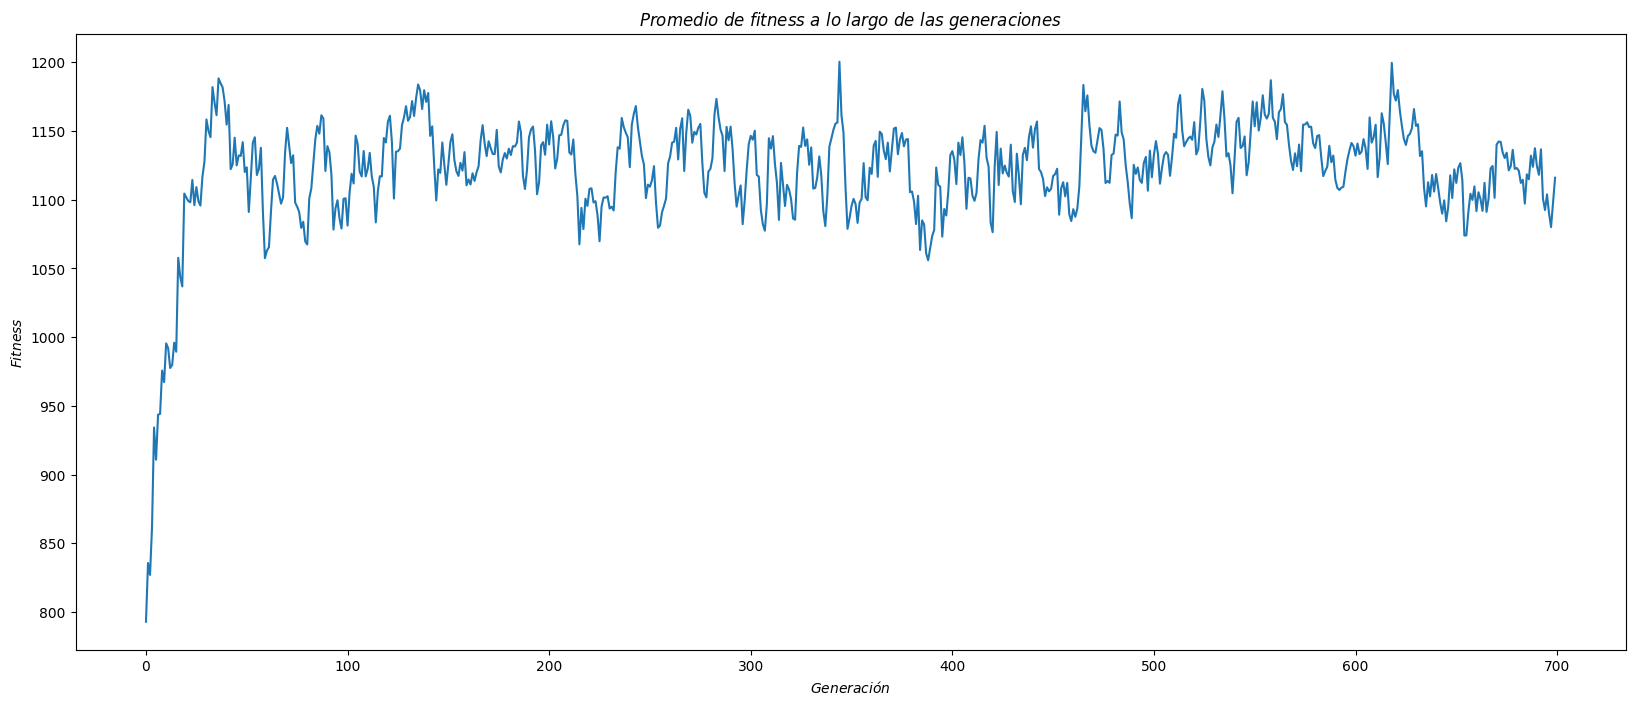

In [17]:
model_2.pop.mean_fitness()

### **Modelos. Selección Torneo y Cruce Custom Single**

**Modelo. Mutación = Flip**

In [18]:
model_3 = GeneticAlgorithm(population_1, class_select='t',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_3_bestind, model_3_bestfit = model_3.run()
print("Best individual: ",''.join(model_3_bestind))
print("Best fitness: ",model_3_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F+][F+F]FF
Best fitness:  1410


In [19]:
index=2
best_finalind[index]=model_3_bestind
best_gen_inds[index]=model_3.pop.best_ind.flatten()

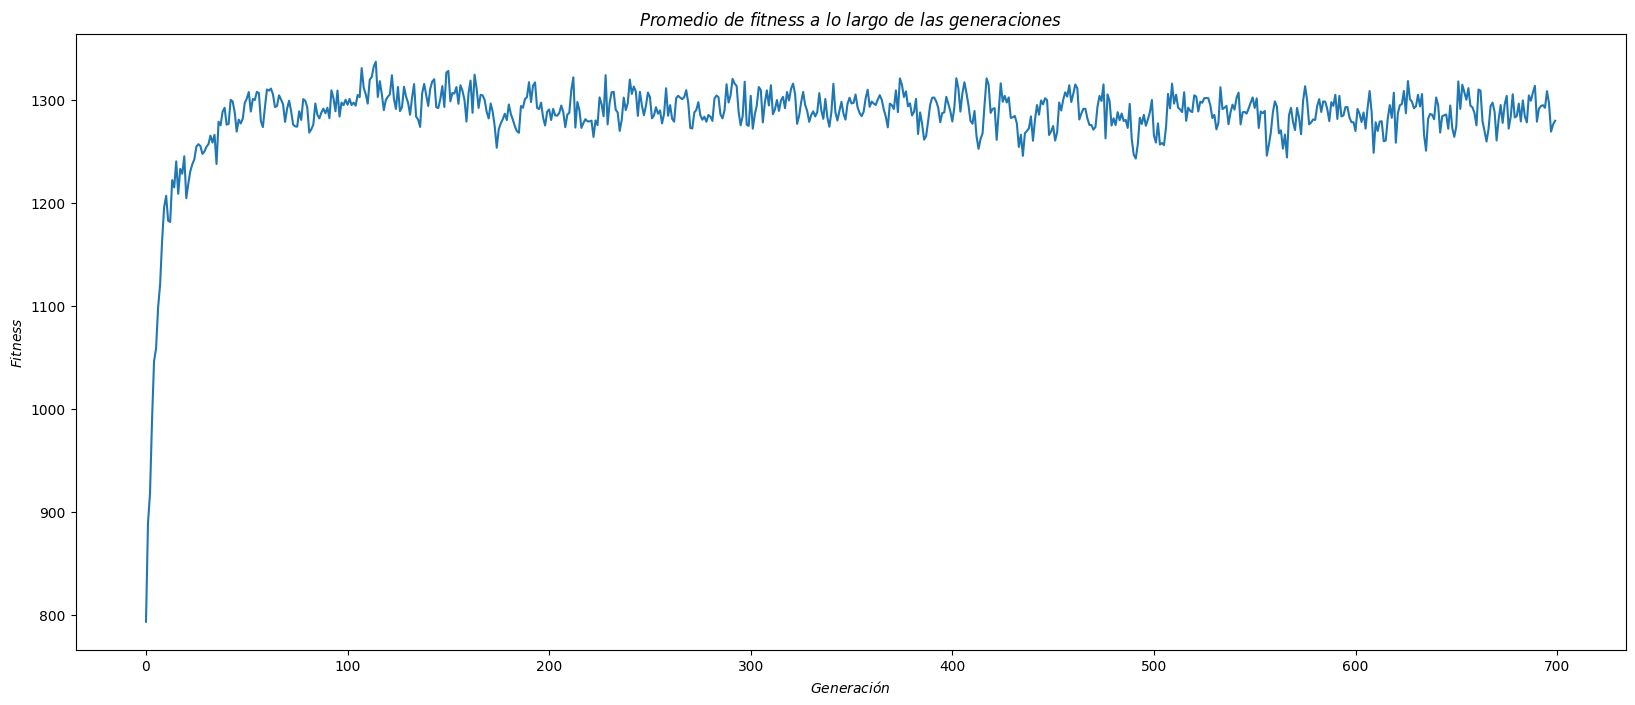

In [20]:
model_3.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [21]:
model_4 = GeneticAlgorithm(population_1, class_select='t',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_4_bestind, model_4_bestfit = model_4.run()
print("Best individual: ",''.join(model_4_bestind))
print("Best fitness: ",model_4_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F-F][F-F]F
Best fitness:  1450


In [22]:
index=3
best_finalind[index]=model_4_bestind
best_gen_inds[index]=model_4.pop.best_ind.flatten()

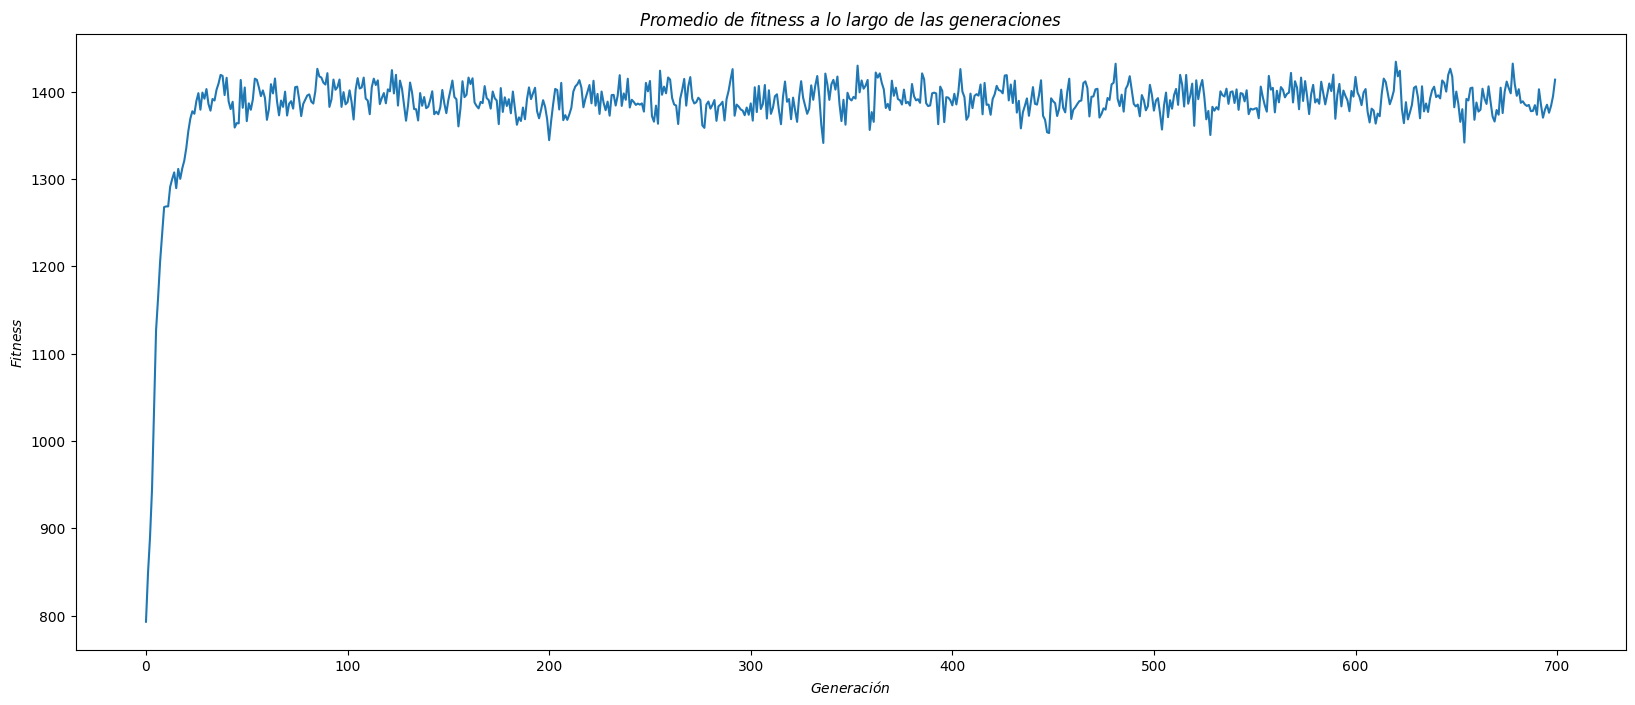

In [23]:
model_4.pop.mean_fitness()

### **Modelo. Selección Rank Based y Cruce Custom Single.**

**Modelo. Mutación = Flip**

In [24]:
model_5 = GeneticAlgorithm(population_1, class_select='rb',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_5_bestind, model_5_bestfit = model_5.run()
print("Best individual: ",''.join(model_5_bestind))
print("Best fitness: ",model_5_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[FF+]FF+FF-
Best fitness:  1300


In [25]:
index=4
best_finalind[index]=model_5_bestind
best_gen_inds[index]=model_5.pop.best_ind.flatten()

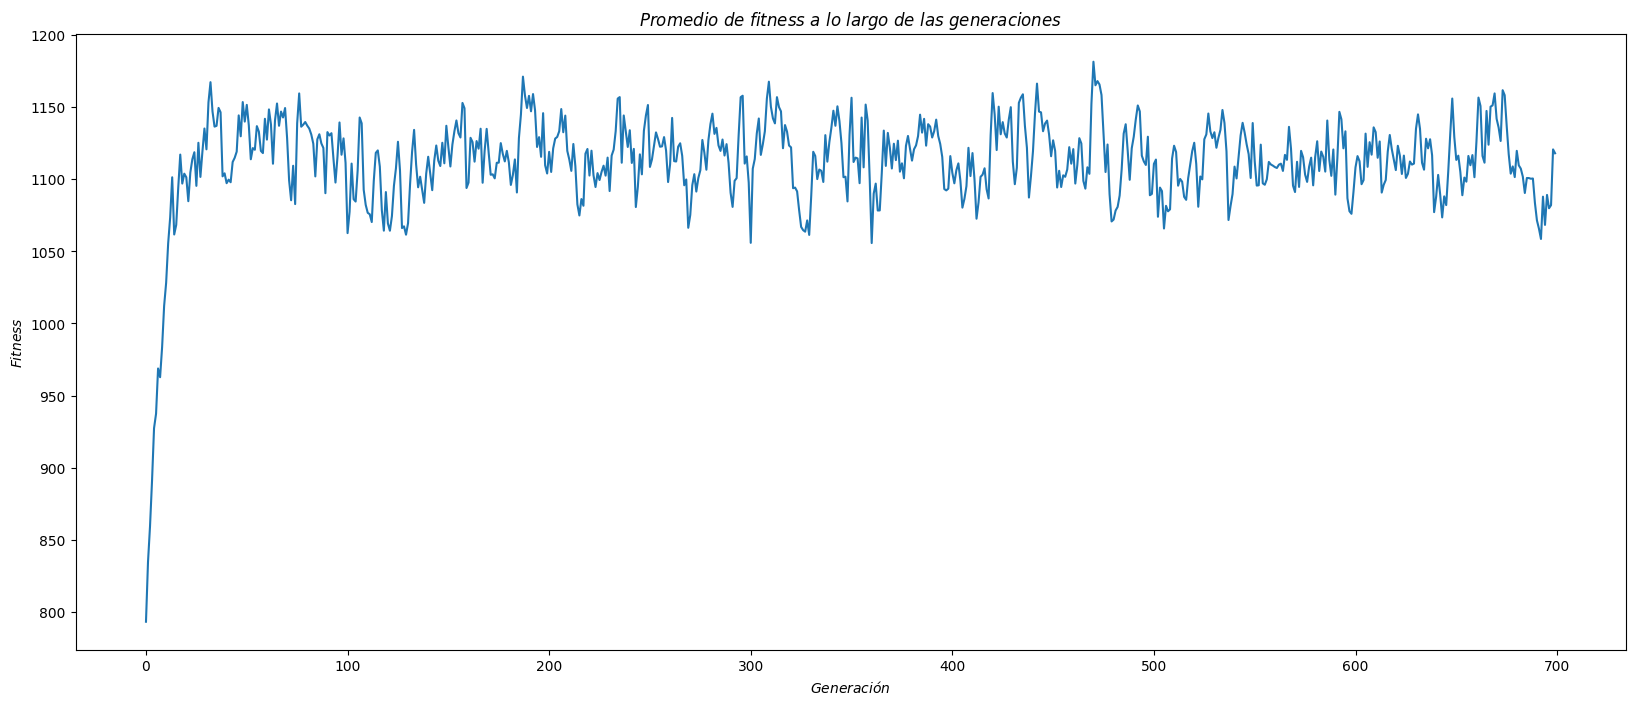

In [26]:
model_5.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [27]:
model_6 = GeneticAlgorithm(population_1, class_select='rb',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_6_bestind, model_6_bestfit = model_6.run()
print("Best individual: ",''.join(model_6_bestind))
print("Best fitness: ",model_6_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[+F]FF[F+F]
Best fitness:  1410


In [28]:
index=5
best_finalind[index]=model_6_bestind
best_gen_inds[index]=model_6.pop.best_ind.flatten()

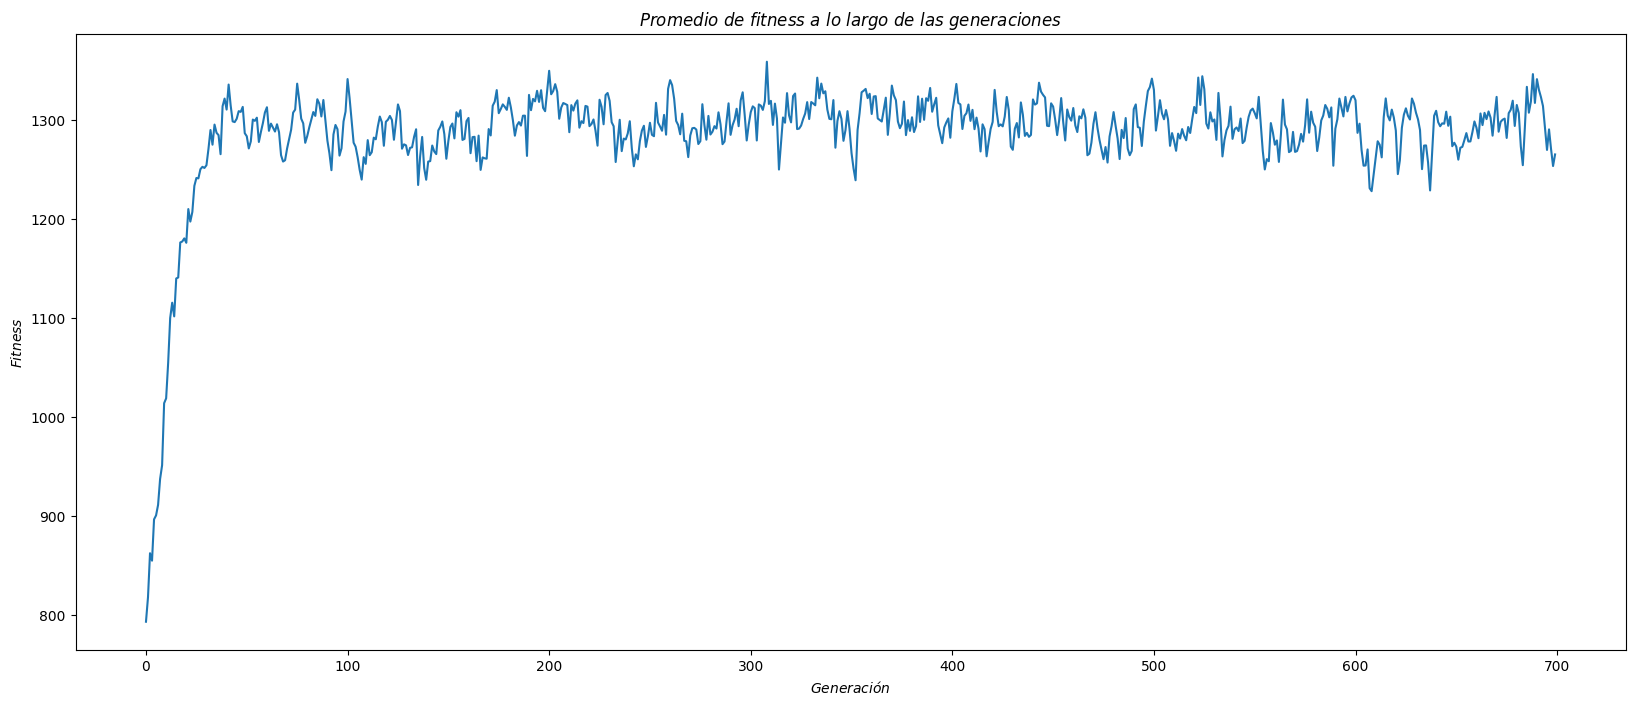

In [29]:
model_6.pop.mean_fitness()

## **Experimentos: Con elitismo, Tamaño de axiomas 12**

### **Modelos. Selección Ruleta y Cruce Custom Single**

**Modelo. Mutación = Swap**

In [30]:
model_7 = GeneticAlgorithm(population_1, class_select='rw',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_7_bestind, model_7_bestfit = model_7.run()
print("Best individual: ",''.join(model_7_bestind))
print("Best fitness: ",model_7_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F-F][F-F]F
Best fitness:  1450


In [31]:
index=6
best_finalind[index]=model_7_bestind
best_gen_inds[index]=model_7.pop.best_ind.flatten()

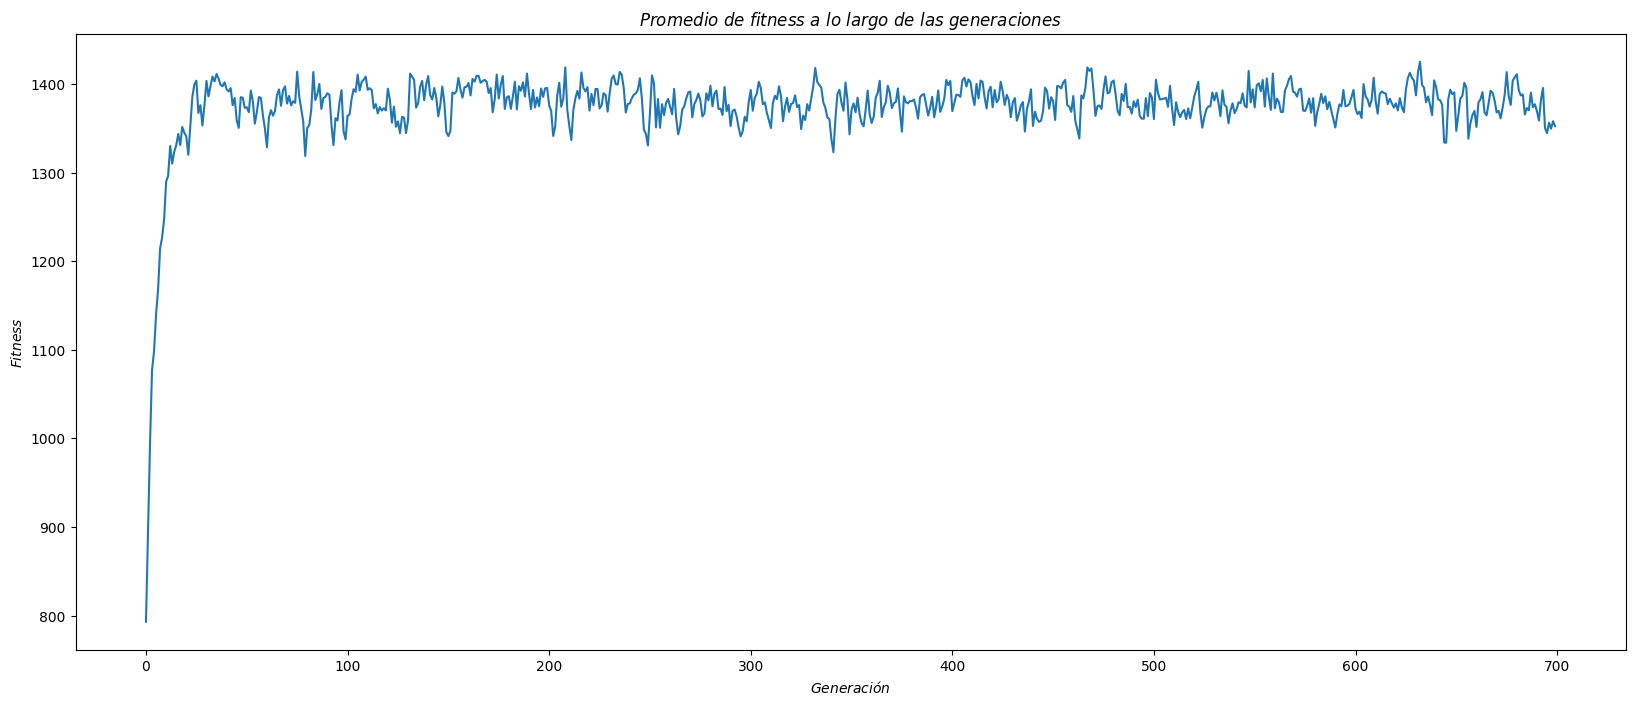

In [32]:
model_7.pop.mean_fitness()

**Modelo. Mutación = Flip**

In [33]:
model_8 = GeneticAlgorithm(population_1, class_select='rw',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_8_bestind, model_8_bestfit = model_8.run()
print("Best individual: ",''.join(model_8_bestind))
print("Best fitness: ",model_8_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  FF[F+F][F+F]
Best fitness:  1450


In [34]:
index=7
best_finalind[index]=model_8_bestind
best_gen_inds[index]=model_8.pop.best_ind.flatten()

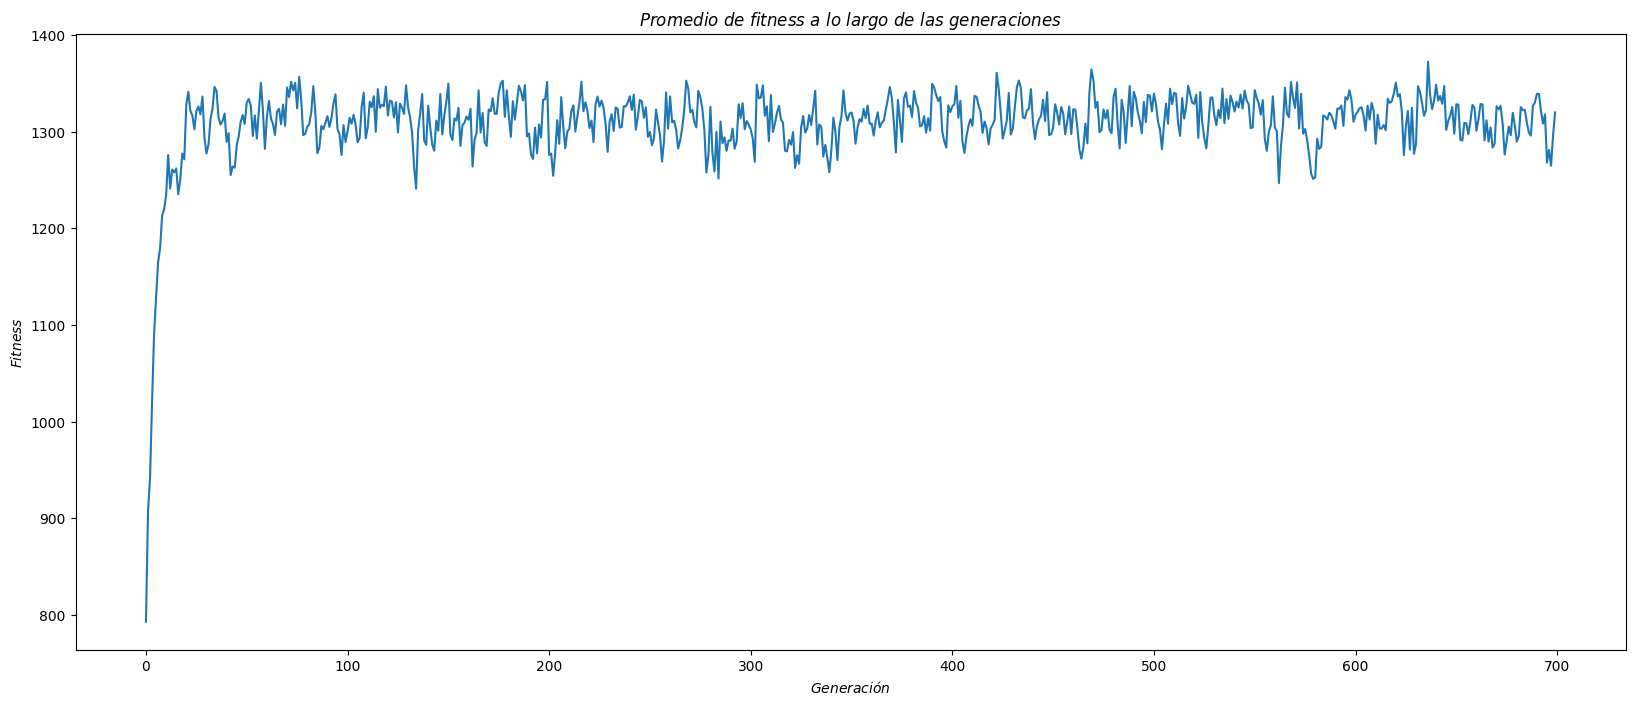

In [35]:
model_8.pop.mean_fitness()

### **Modelos. Selección Torneo y Cruce Custom Single**

**Modelo. Mutación = Flip**

In [36]:
model_9 = GeneticAlgorithm(population_1, class_select='t',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_9_bestind, model_9_bestfit = model_9.run()
print("Best individual: ",''.join(model_9_bestind))
print("Best fitness: ",model_9_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[+F]FF[F+F]
Best fitness:  1410


In [37]:
index=8
best_finalind[index]=model_9_bestind
best_gen_inds[index]=model_9.pop.best_ind.flatten()

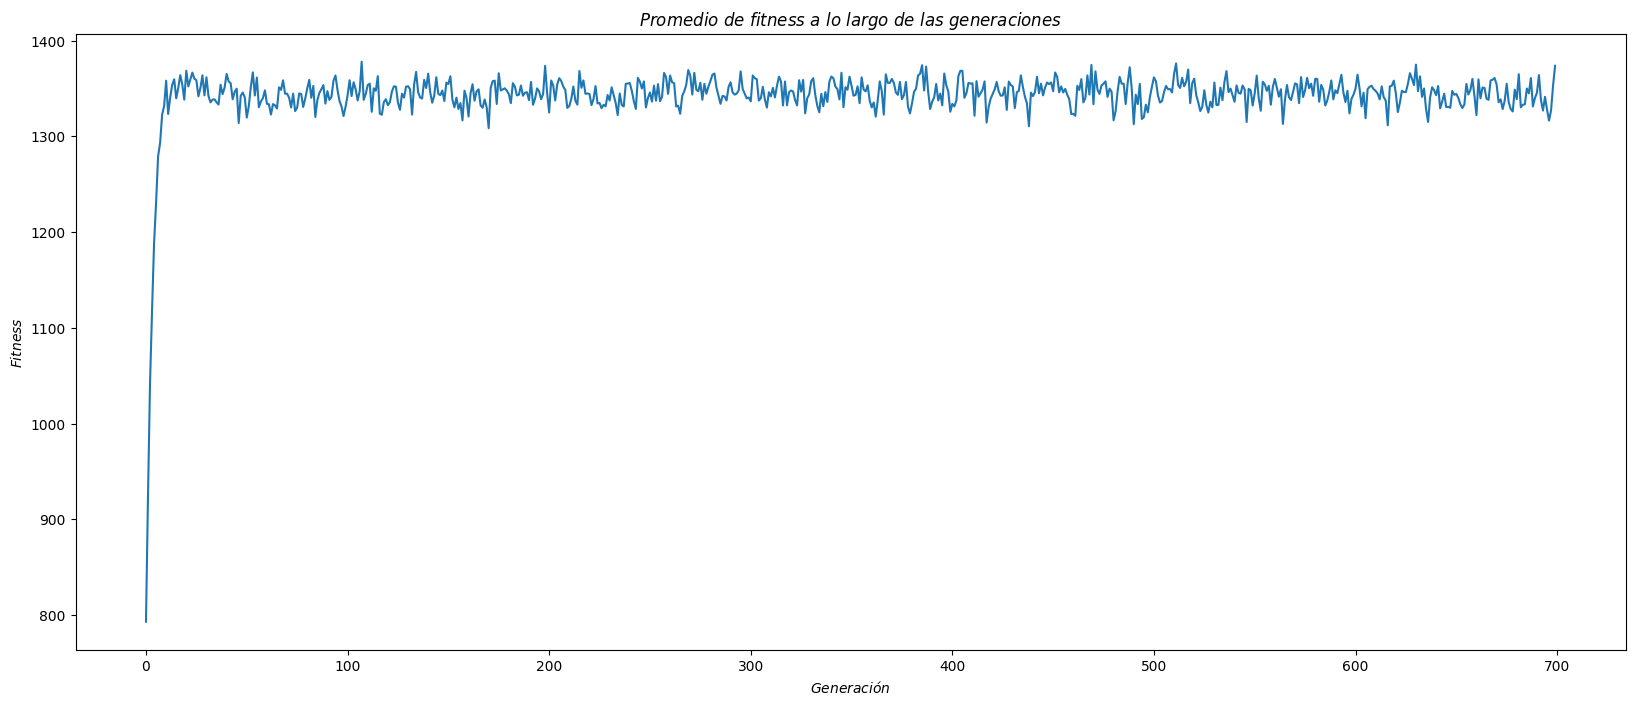

In [38]:
model_9.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [39]:
model_10 = GeneticAlgorithm(population_1, class_select='t',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_10_bestind, model_10_bestfit = model_10.run()
print("Best individual: ",''.join(model_10_bestind))
print("Best fitness: ",model_10_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[-F]FF[F-F]
Best fitness:  1410


In [40]:
index=9
best_finalind[index]=model_10_bestind
best_gen_inds[index]=model_10.pop.best_ind.flatten()

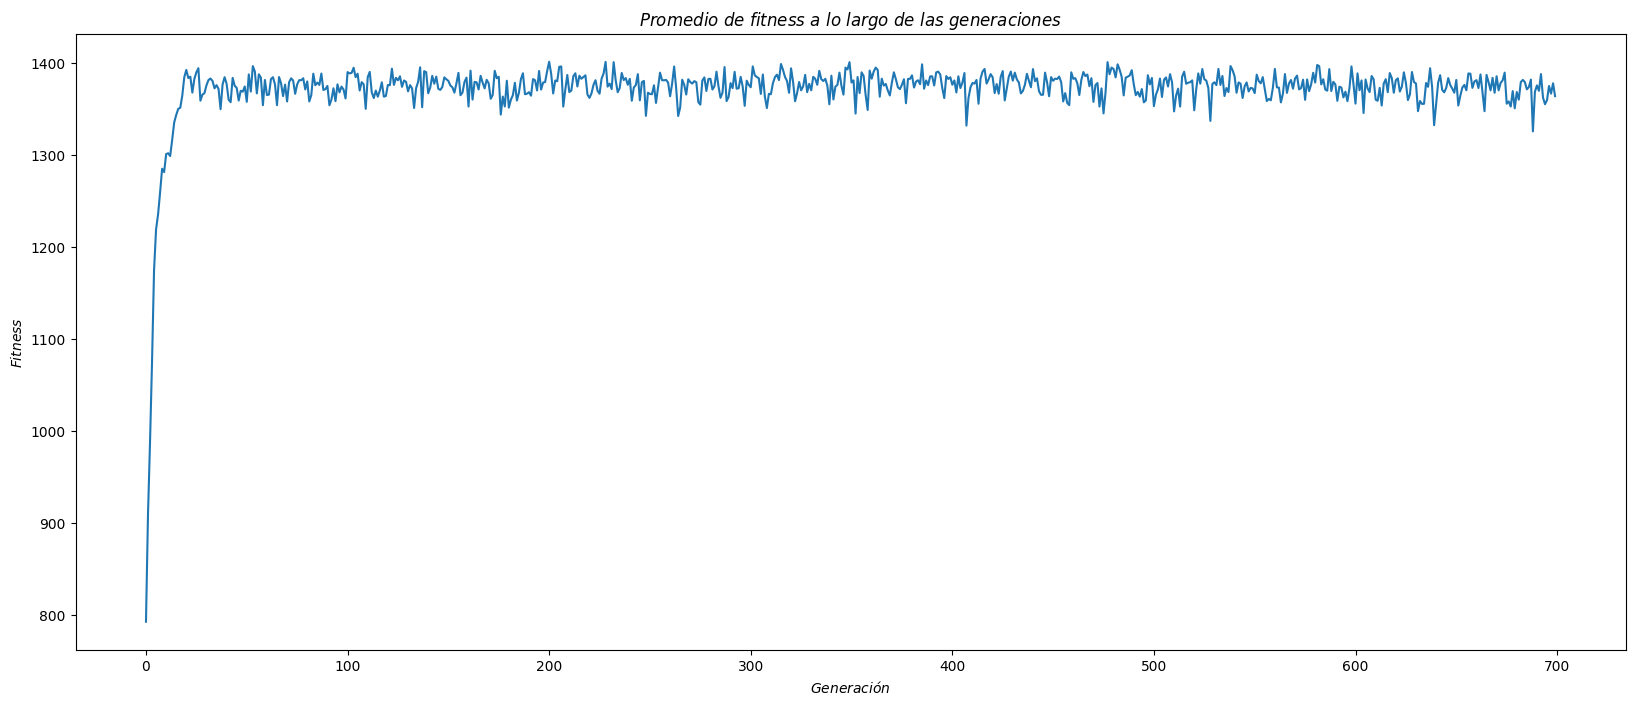

In [41]:
model_10.pop.mean_fitness()

### **Modelo. Selección Rank Based y Cruce Custom Single.**

**Modelo. Mutación = Flip**

In [42]:
model_11 = GeneticAlgorithm(population_1, class_select='rb',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_11_bestind, model_11_bestfit = model_11.run()
print("Best individual: ",''.join(model_11_bestind))
print("Best fitness: ",model_11_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F-F][F-F]F
Best fitness:  1450


In [43]:
index=10
best_finalind[index]=model_11_bestind
best_gen_inds[index]=model_11.pop.best_ind.flatten()

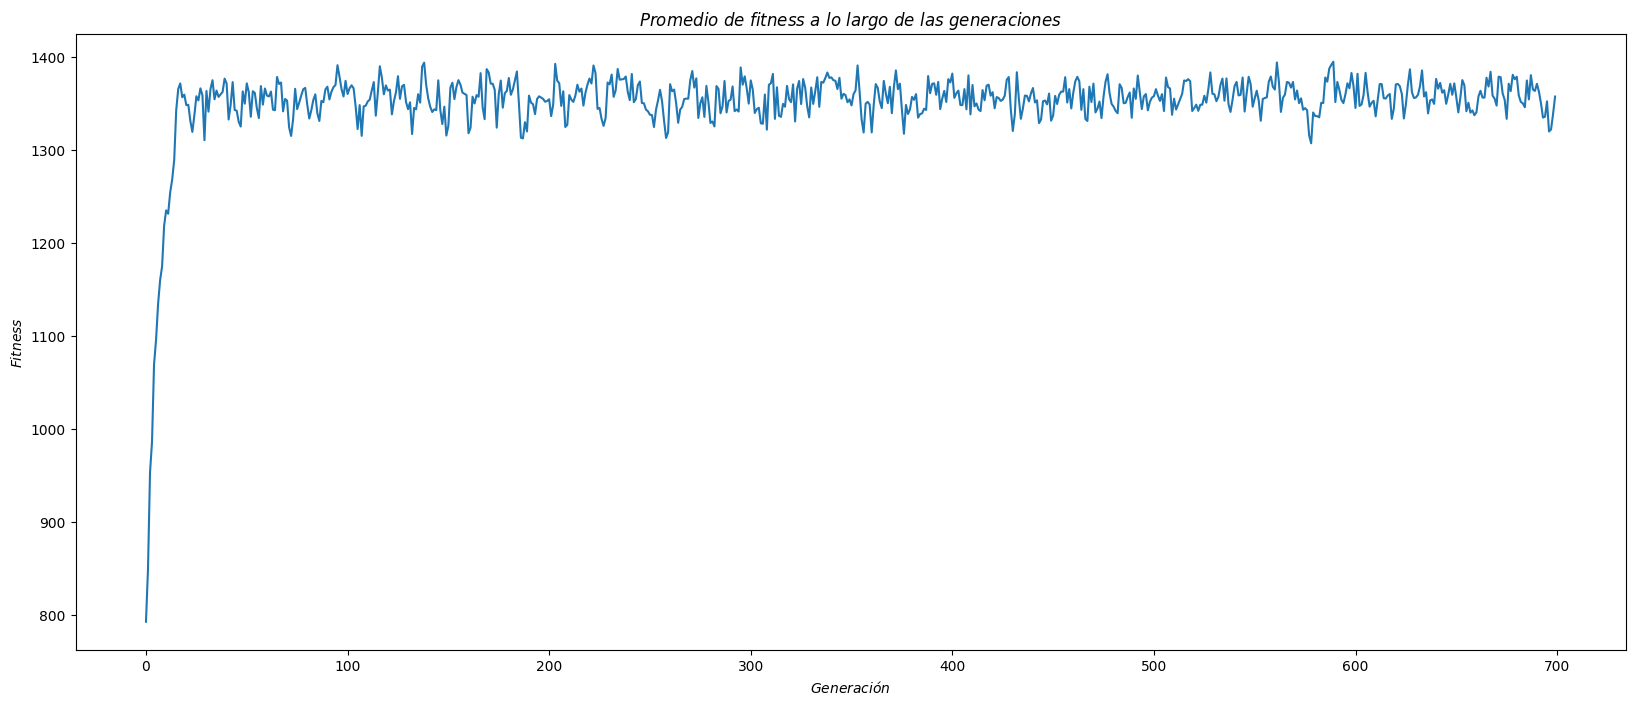

In [44]:
model_11.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [45]:
model_12 = GeneticAlgorithm(population_1, class_select='rb',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_12_bestind, model_12_bestfit = model_12.run()
print("Best individual: ",''.join(model_12_bestind))
print("Best fitness: ",model_12_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[-F][F-F]FF
Best fitness:  1410


In [46]:
index=11
best_finalind[index]=model_12_bestind
best_gen_inds[index]=model_12.pop.best_ind.flatten()

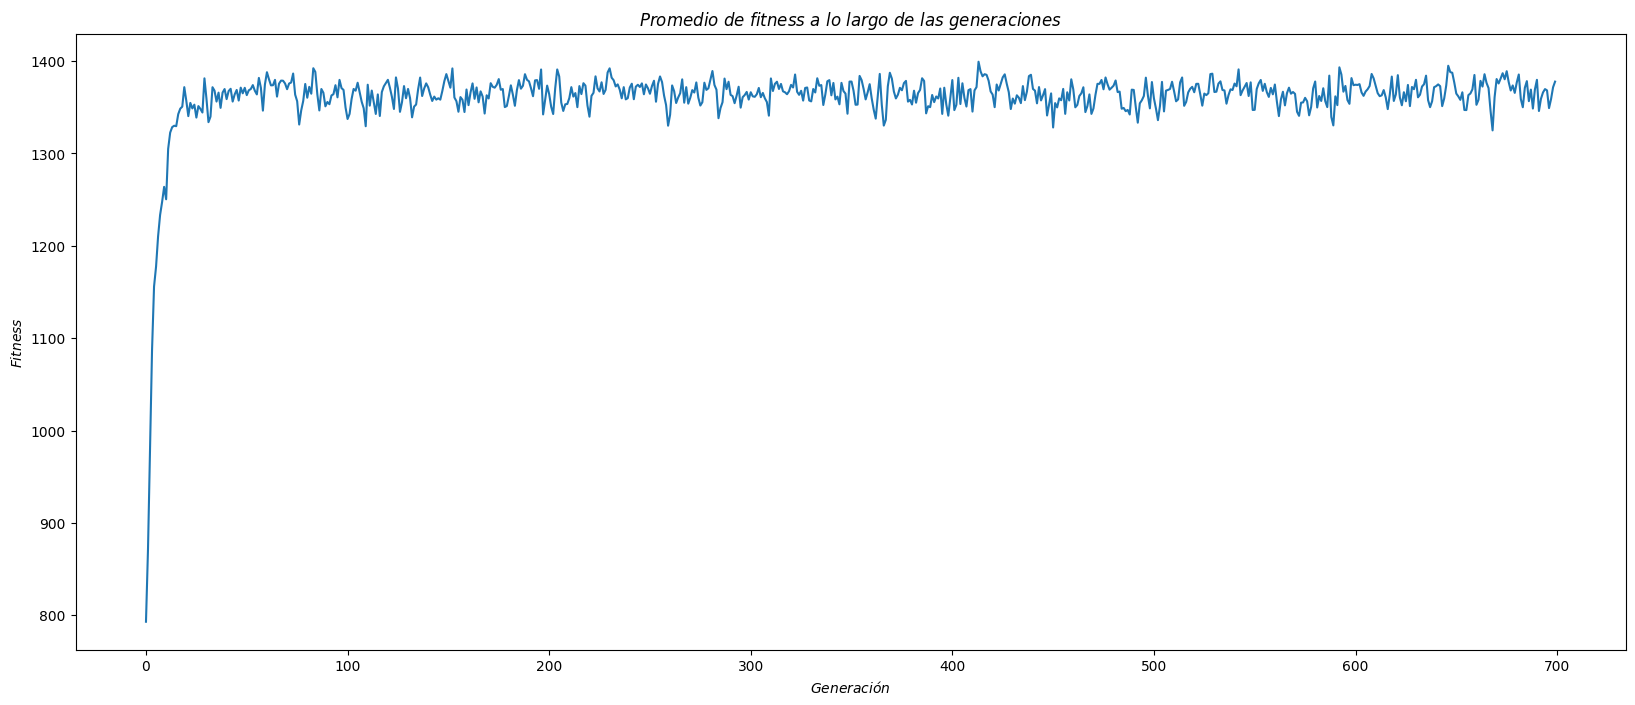

In [47]:
model_12.pop.mean_fitness()

**Se guarda la información de las matrices en ficheros numpy para su posterior visualización**

In [48]:
np.save('best_final_ind_exp1.npy', best_finalind)
np.save('best_gen_inds_exp1.npy', best_gen_inds)

## **Experimentos: Sin elitismo, Tamaño de axiomas 16**

**Inicialización de población de individuos**

In [49]:
n_ = 100
size_ = 16

population_rules_16 = []
for i in range(n_):
    population_rules_16.append(generate_axiom(['F'], size_))
population_2 = Population(pop_r=population_rules_16,n=n_,size=size_)
population_2.init_population()

**Inicialización de arreglos que contendran los datos de mejores individuos finales y por generaciones de todos los modelos creados.**

In [50]:
best_finalind=np.empty((12, 16), dtype=object)
best_gen_inds=np.empty((12,11200),dtype=object)

### **Modelos. Selección Ruleta y Cruce Custom Single**

**Modelo. Mutación = Swap**

In [51]:
model_13 = GeneticAlgorithm(population_2, class_select='rw',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_13_bestind, model_13_bestfit = model_13.run()
print("Best individual: ",''.join(model_13_bestind))
print("Best fitness: ",model_13_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F+F]FFF[F+F]FF
Best fitness:  1510


In [52]:
index=0
best_finalind[index]=model_13_bestind
best_gen_inds[index]=model_13.pop.best_ind.flatten()

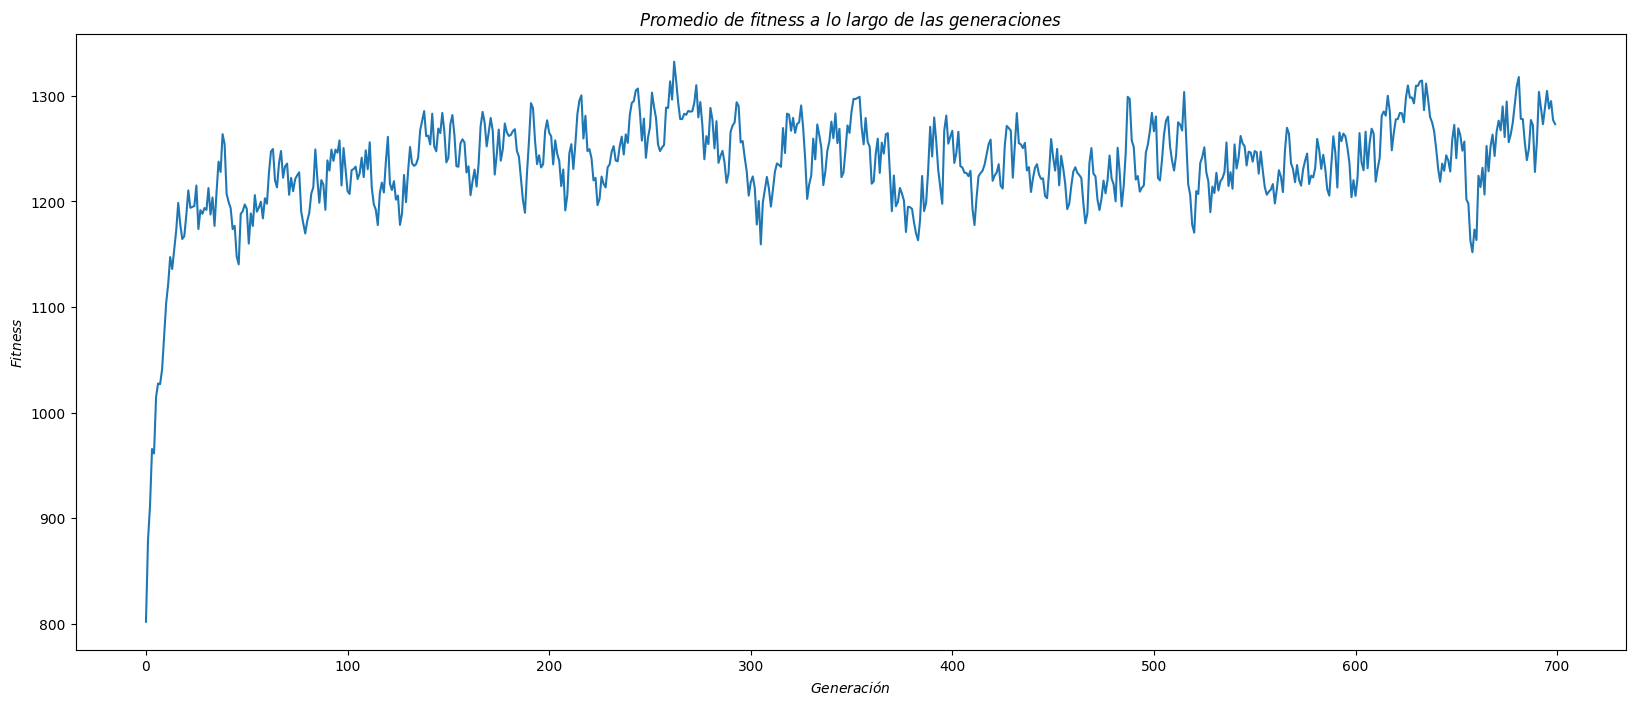

In [53]:
model_13.pop.mean_fitness()

**Modelo. Mutación = Flip**

In [54]:
model_14 = GeneticAlgorithm(population_2, class_select='rw',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_14_bestind, model_14_bestfit = model_14.run()
print("Best individual: ",''.join(model_14_bestind))
print("Best fitness: ",model_14_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[-F]F[-F][F-]FF
Best fitness:  1505


In [55]:
index=1
best_finalind[index]=model_14_bestind
best_gen_inds[index]=model_14.pop.best_ind.flatten()

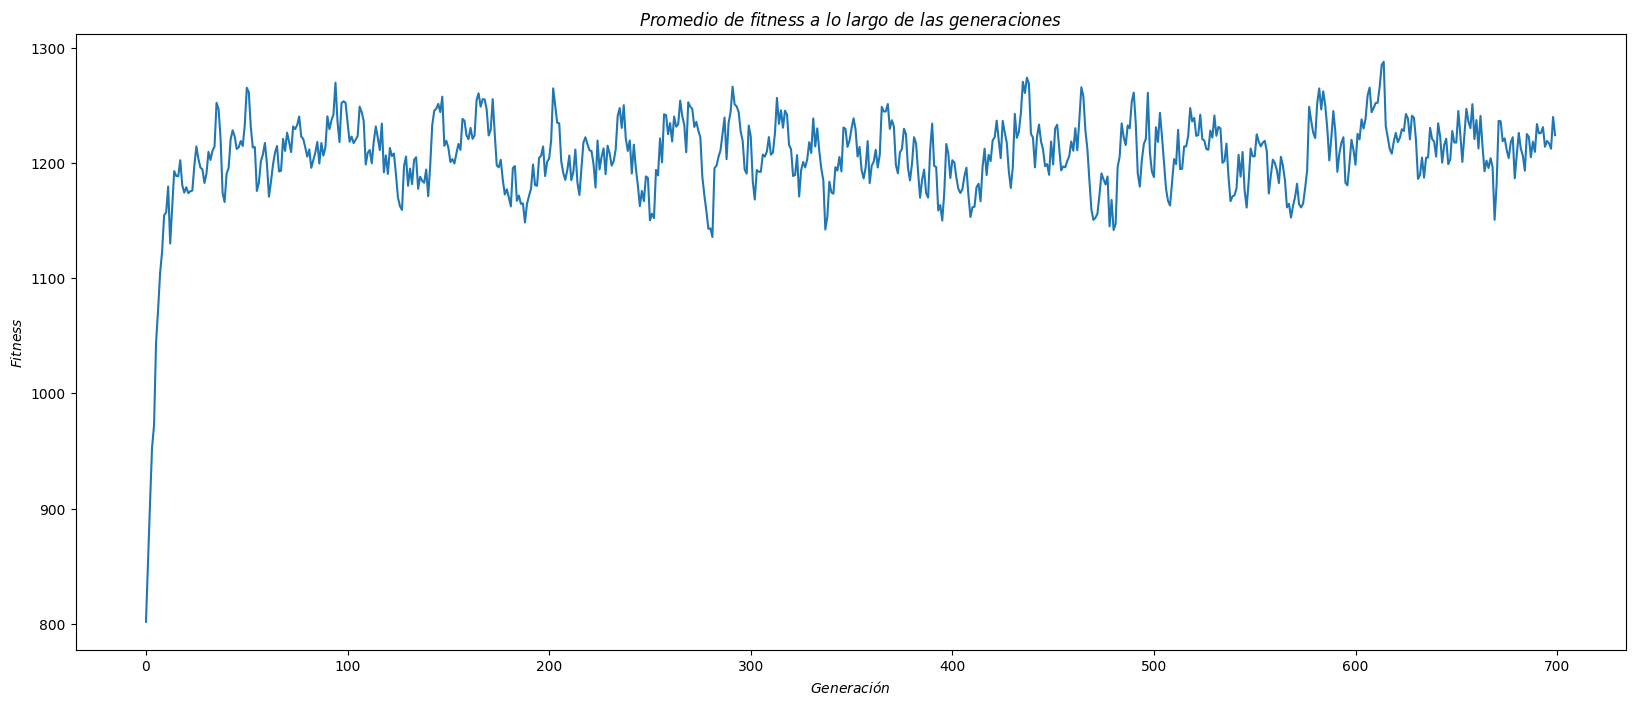

In [56]:
model_14.pop.mean_fitness()

### **Modelos. Selección Torneo y Cruce Custom Single**

**Modelo. Mutación = Flip**

In [57]:
model_15 = GeneticAlgorithm(population_2, class_select='t',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_15_bestind, model_15_bestfit = model_15.run()
print("Best individual: ",''.join(model_15_bestind))
print("Best fitness: ",model_15_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[+F][F-F][-F]FF
Best fitness:  1545


In [58]:
index=2
best_finalind[index]=model_15_bestind
best_gen_inds[index]=model_15.pop.best_ind.flatten()

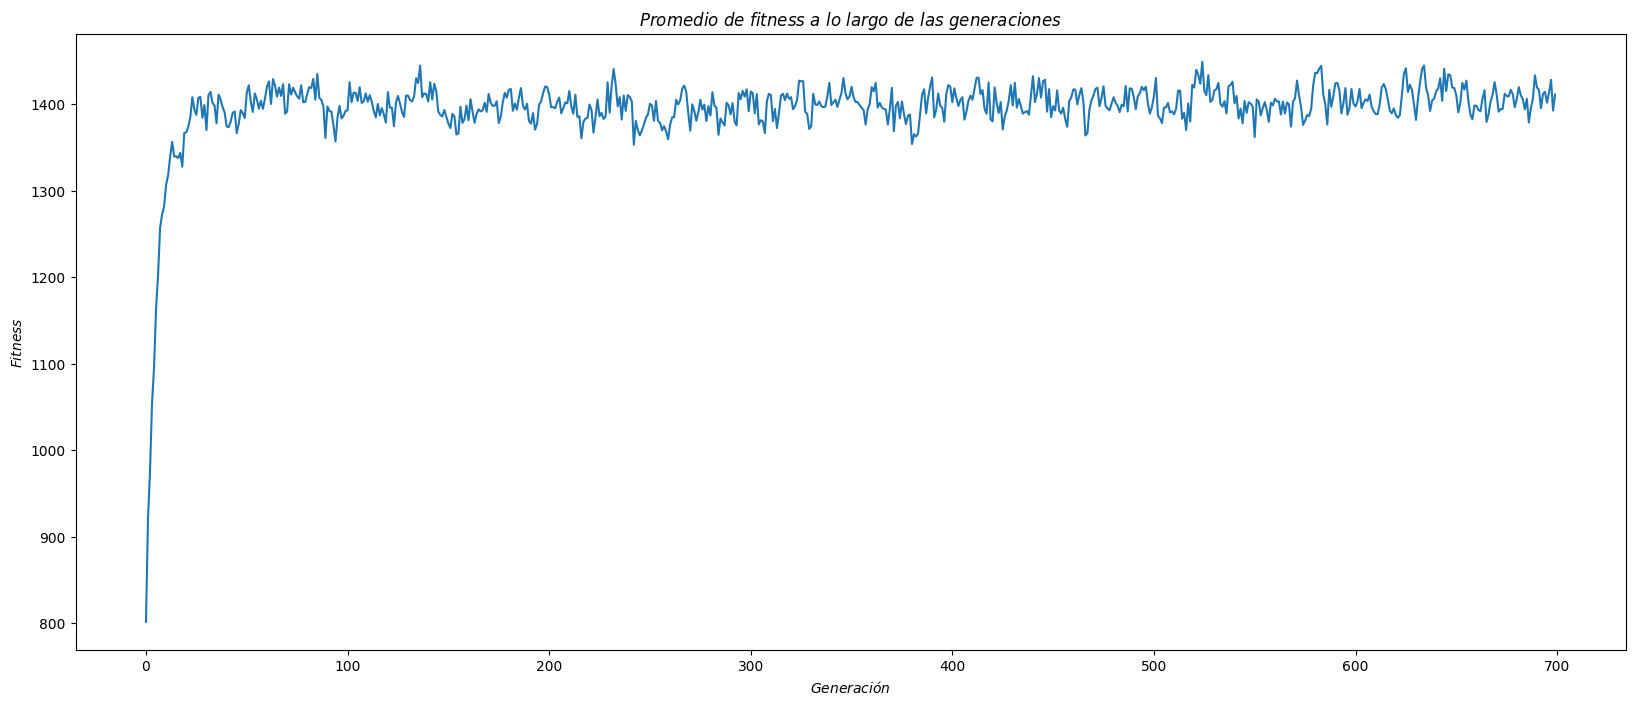

In [59]:
model_15.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [60]:
model_16 = GeneticAlgorithm(population_2, class_select='t',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_16_bestind, model_16_bestfit = model_16.run()
print("Best individual: ",''.join(model_16_bestind))
print("Best fitness: ",model_16_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F-F]F+FFF-[-F]
Best fitness:  1500


In [61]:
index=3
best_finalind[index]=model_16_bestind
best_gen_inds[index]=model_16.pop.best_ind.flatten()

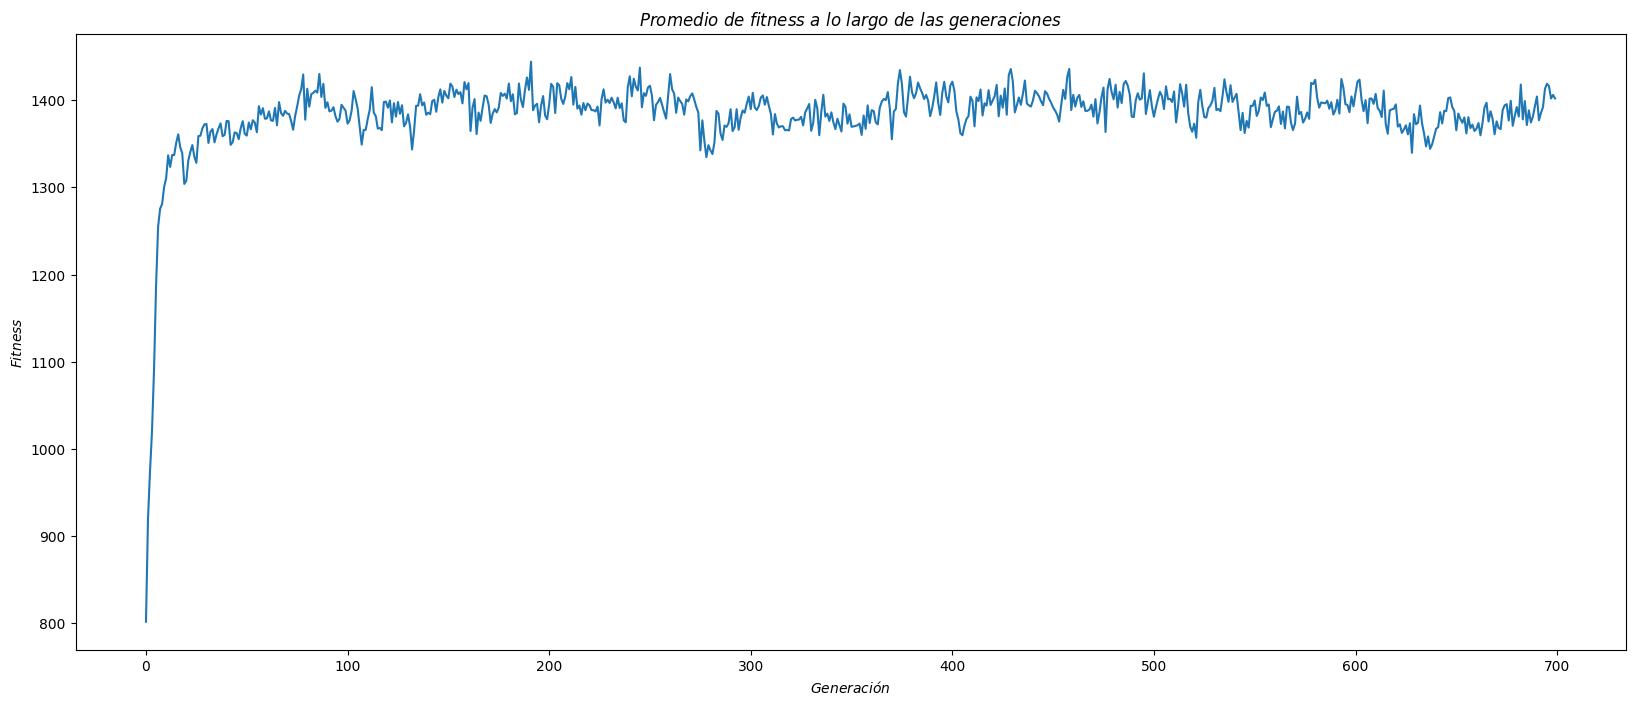

In [62]:
model_16.pop.mean_fitness()

### **Modelo. Selección Rank Based y Cruce Custom Single.**

**Modelo. Mutación = Flip**

In [63]:
model_17 = GeneticAlgorithm(population_2, class_select='rb',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_17_bestind, model_17_bestfit = model_17.run()
print("Best individual: ",''.join(model_17_bestind))
print("Best fitness: ",model_17_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  FFF[+F][F+F][-F]
Best fitness:  1545


In [64]:
index=4
best_finalind[index]=model_17_bestind
best_gen_inds[index]=model_17.pop.best_ind.flatten()

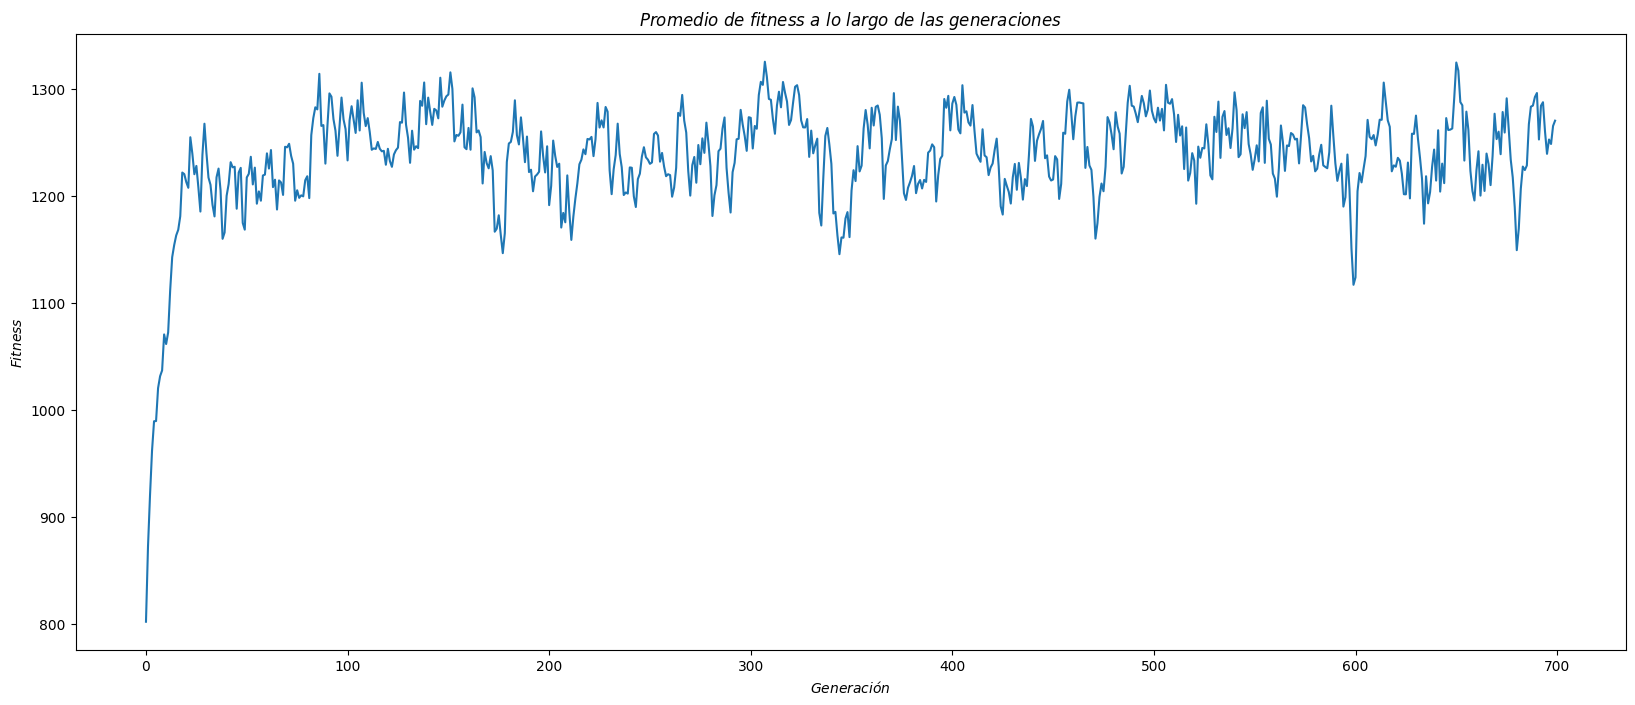

In [65]:
model_17.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [66]:
model_18 = GeneticAlgorithm(population_2, class_select='rb',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0,
                           fitness_func=fitness, max_gen=700)
model_18_bestind, model_18_bestfit = model_18.run()
print("Best individual: ",''.join(model_18_bestind))
print("Best fitness: ",model_18_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F-]-F[F-F]FFF+
Best fitness:  1500


In [67]:
index=5
best_finalind[index]=model_18_bestind
best_gen_inds[index]=model_18.pop.best_ind.flatten()

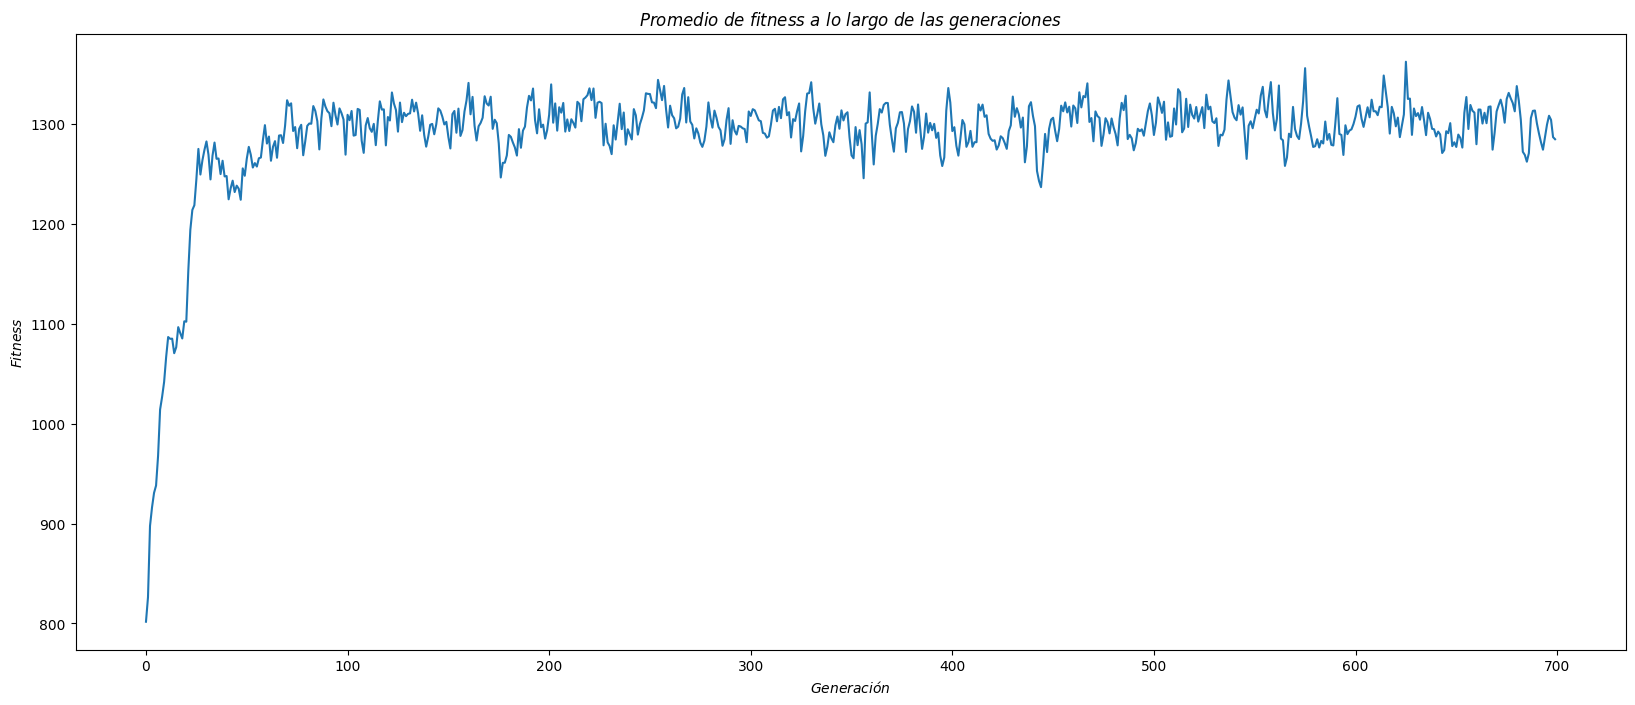

In [68]:
model_18.pop.mean_fitness()

## **Experimentos: Con elitismo, Tamaño de axiomas 16**

### **Modelos. Selección Ruleta y Cruce Custom Single**

**Modelo. Mutación = Swap**

In [69]:
model_19 = GeneticAlgorithm(population_2, class_select='rw',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_19_bestind, model_19_bestfit = model_19.run()
print("Best individual: ",''.join(model_19_bestind))
print("Best fitness: ",model_19_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  FF[F-F][F-][F-]F
Best fitness:  1545


In [70]:
index=6
best_finalind[index]=model_19_bestind
best_gen_inds[index]=model_19.pop.best_ind.flatten()

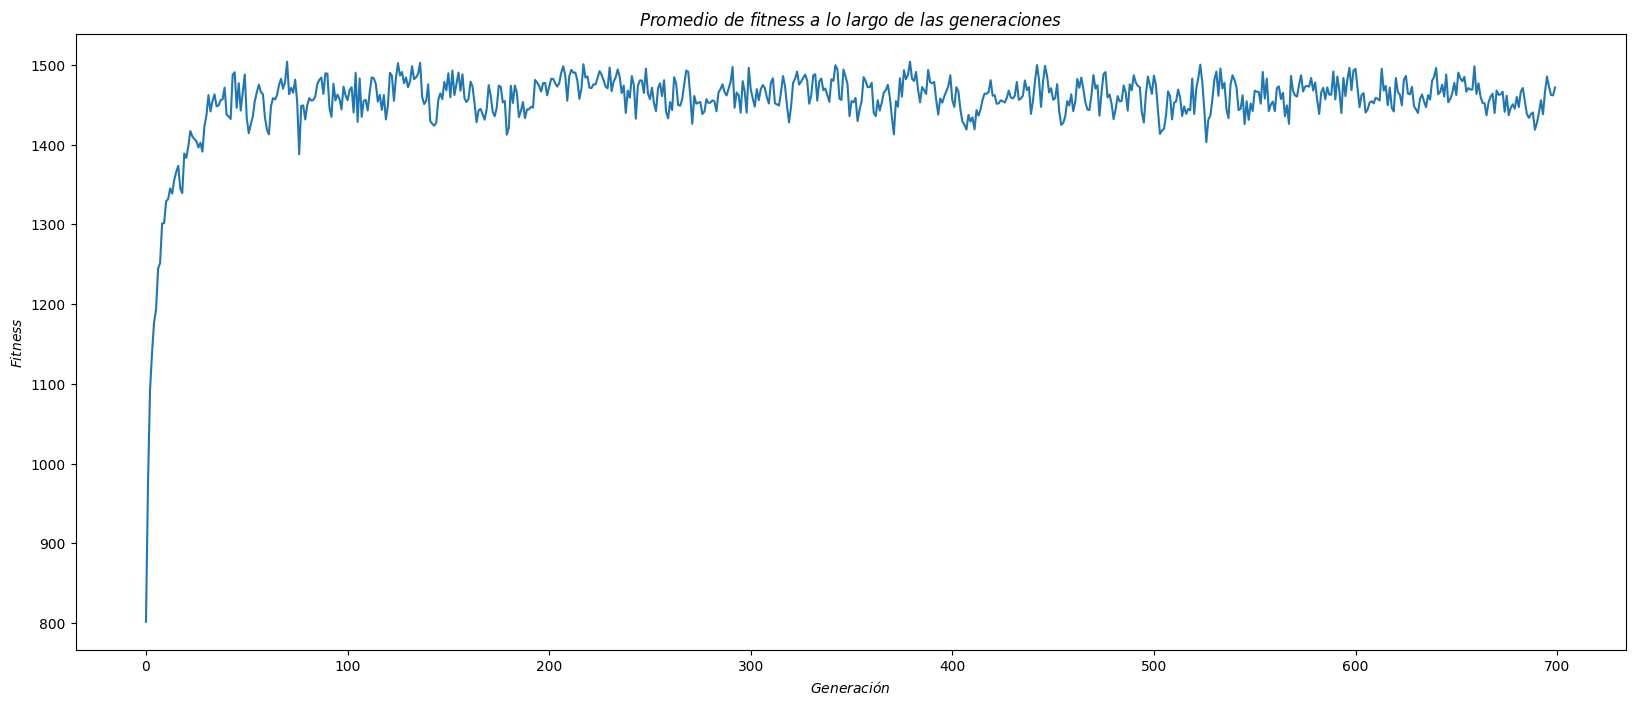

In [71]:
model_19.pop.mean_fitness()

**Modelo. Mutación = Flip**

In [72]:
model_20 = GeneticAlgorithm(population_2, class_select='rw',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_20_bestind, model_20_bestfit = model_20.run()
print("Best individual: ",''.join(model_20_bestind))
print("Best fitness: ",model_20_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  FF[F+][F-]F[F+F]
Best fitness:  1545


In [73]:
index=7
best_finalind[index]=model_20_bestind
best_gen_inds[index]=model_20.pop.best_ind.flatten()

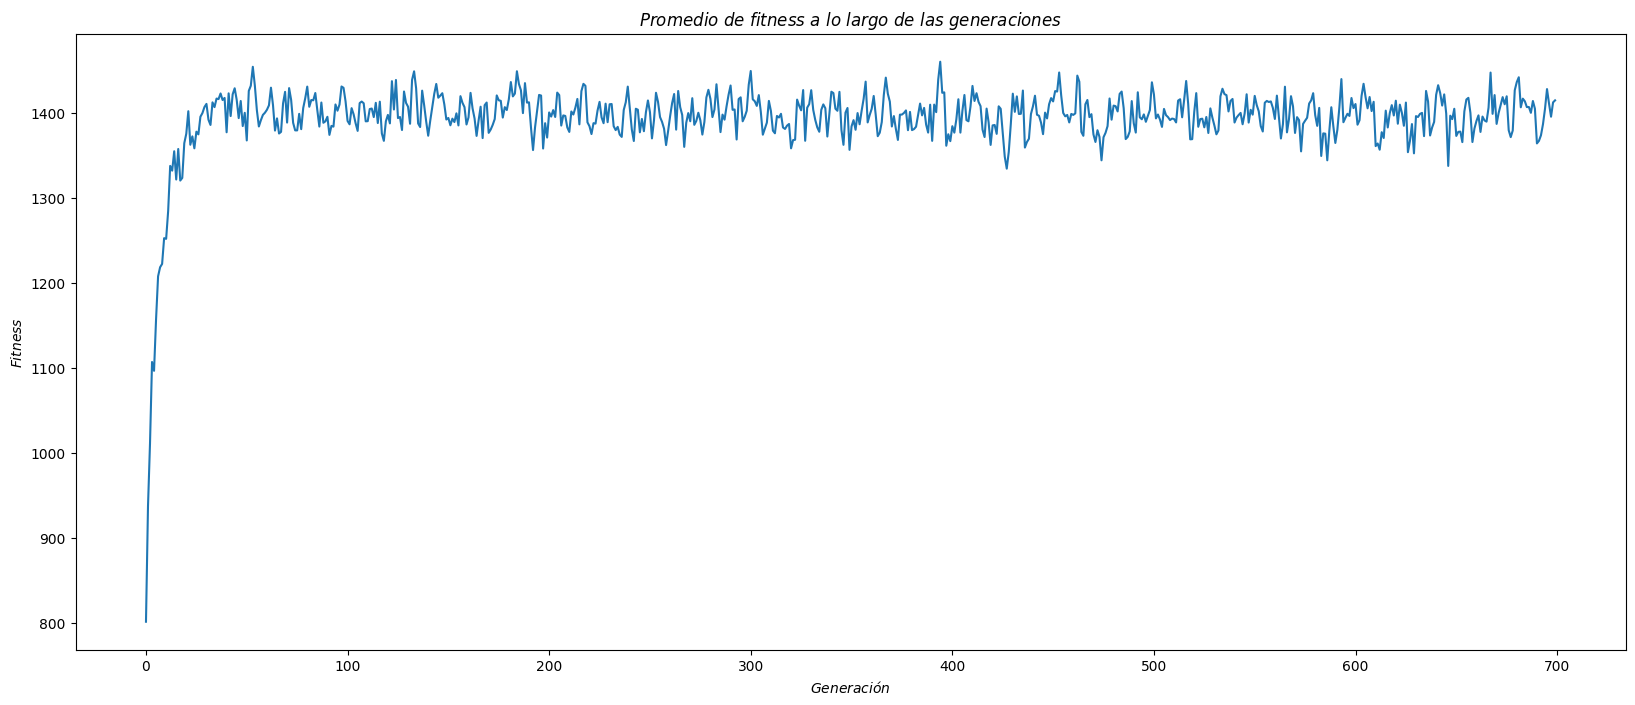

In [74]:
model_20.pop.mean_fitness()

### **Modelos. Selección Torneo y Cruce Custom Single**

**Modelo. Mutación = Flip**

In [75]:
model_21 = GeneticAlgorithm(population_2, class_select='t',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_21_bestind, model_21_bestfit = model_21.run()
print("Best individual: ",''.join(model_21_bestind))
print("Best fitness: ",model_21_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[+F][F+][F-F]FF
Best fitness:  1545


In [76]:
index=8
best_finalind[index]=model_21_bestind
best_gen_inds[index]=model_21.pop.best_ind.flatten()

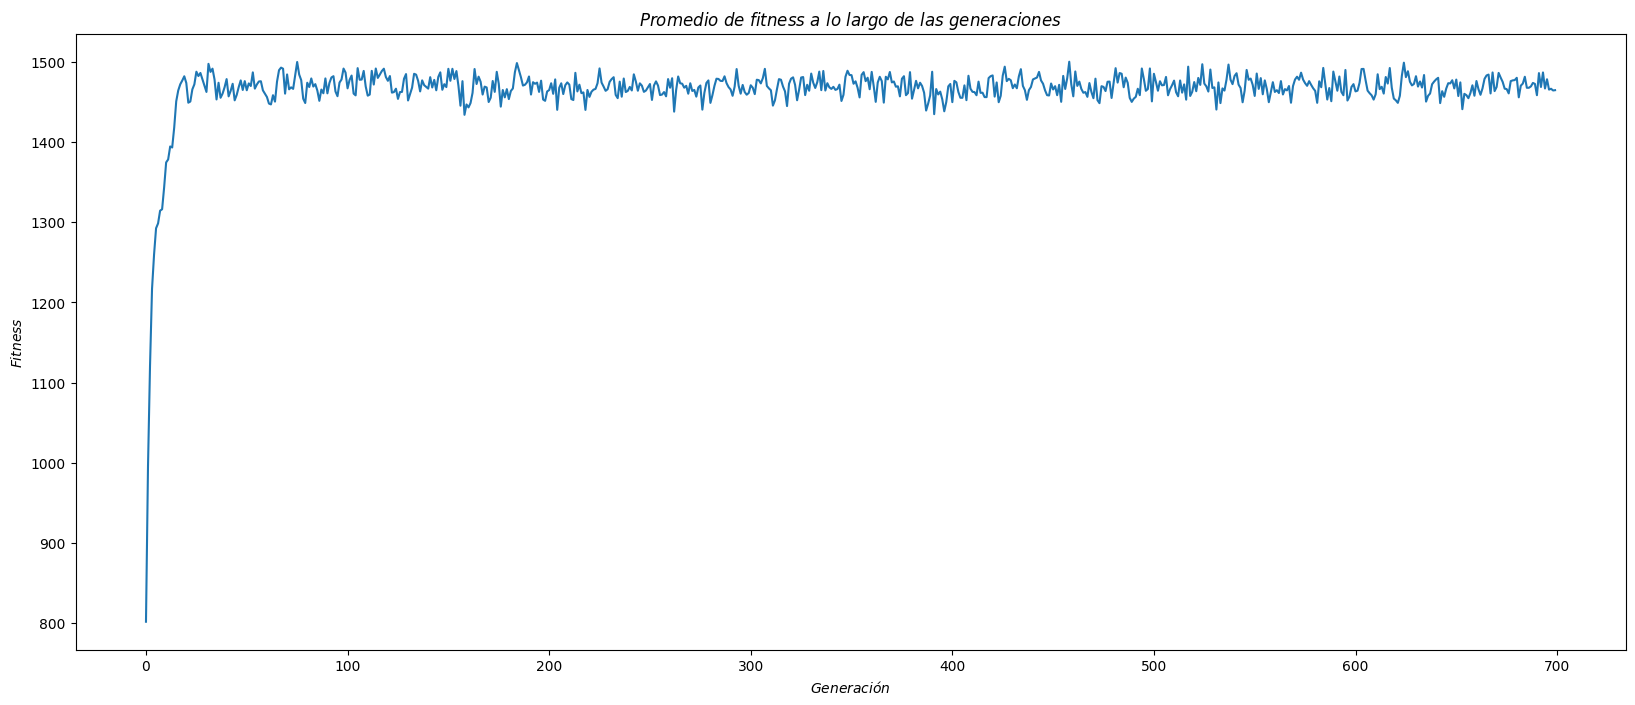

In [77]:
model_21.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [78]:
model_22 = GeneticAlgorithm(population_2, class_select='t',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_22_bestind, model_22_bestfit = model_22.run()
print("Best individual: ",''.join(model_22_bestind))
print("Best fitness: ",model_22_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  F[F-][F-F][-F]FF
Best fitness:  1545


In [79]:
index=9
best_finalind[index]=model_22_bestind
best_gen_inds[index]=model_22.pop.best_ind.flatten()

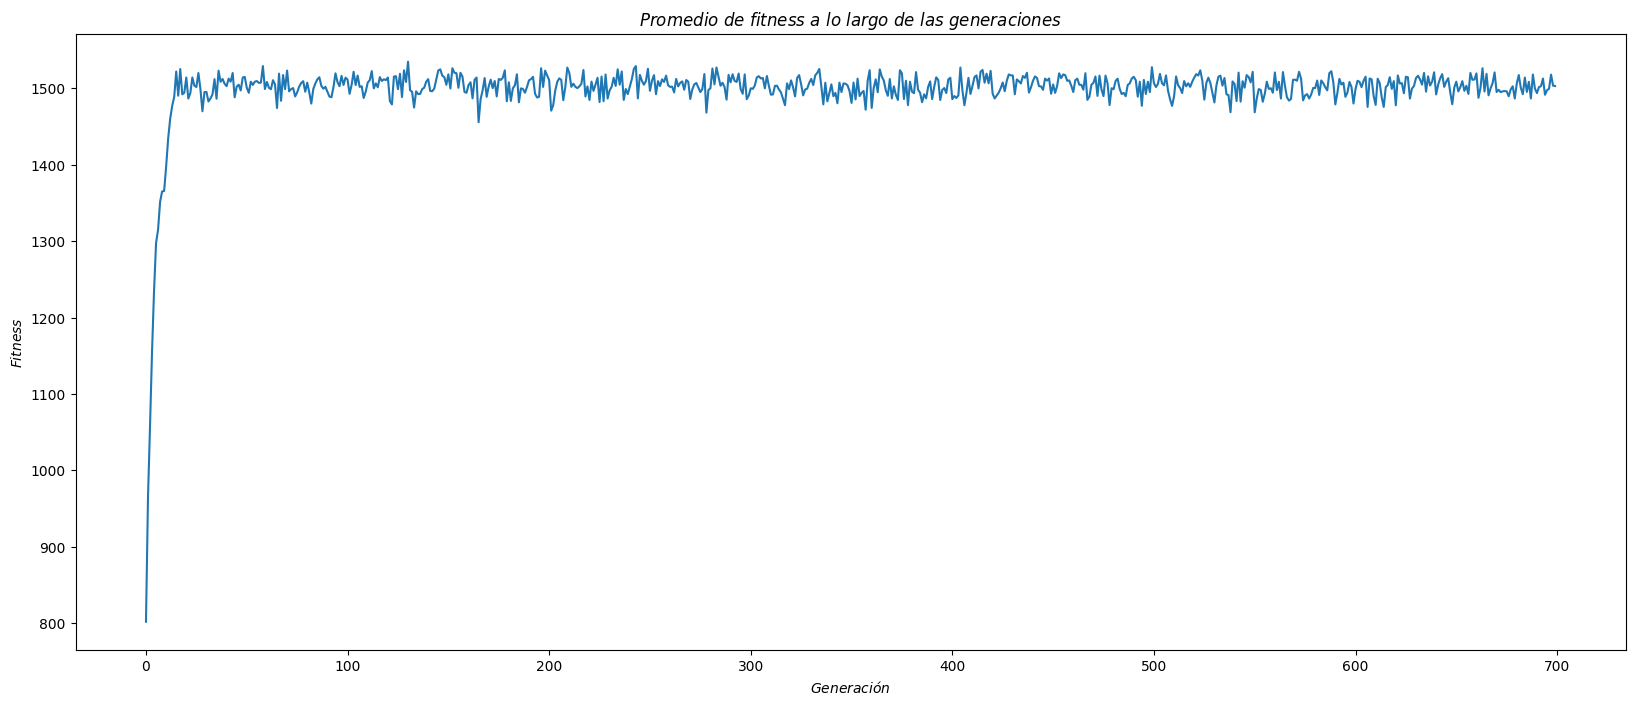

In [80]:
model_22.pop.mean_fitness()

### **Modelo. Selección Rank Based y Cruce Custom Single.**

**Modelo. Mutación = Flip**

In [81]:
model_23 = GeneticAlgorithm(population_2, class_select='rb',
                           class_cross='single', class_mut='flip',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_23_bestind, model_23_bestfit = model_23.run()
print("Best individual: ",''.join(model_23_bestind))
print("Best fitness: ",model_23_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  FF[+F][F+]F[F+F]
Best fitness:  1545


In [82]:
index=10
best_finalind[index]=model_23_bestind
best_gen_inds[index]=model_23.pop.best_ind.flatten()

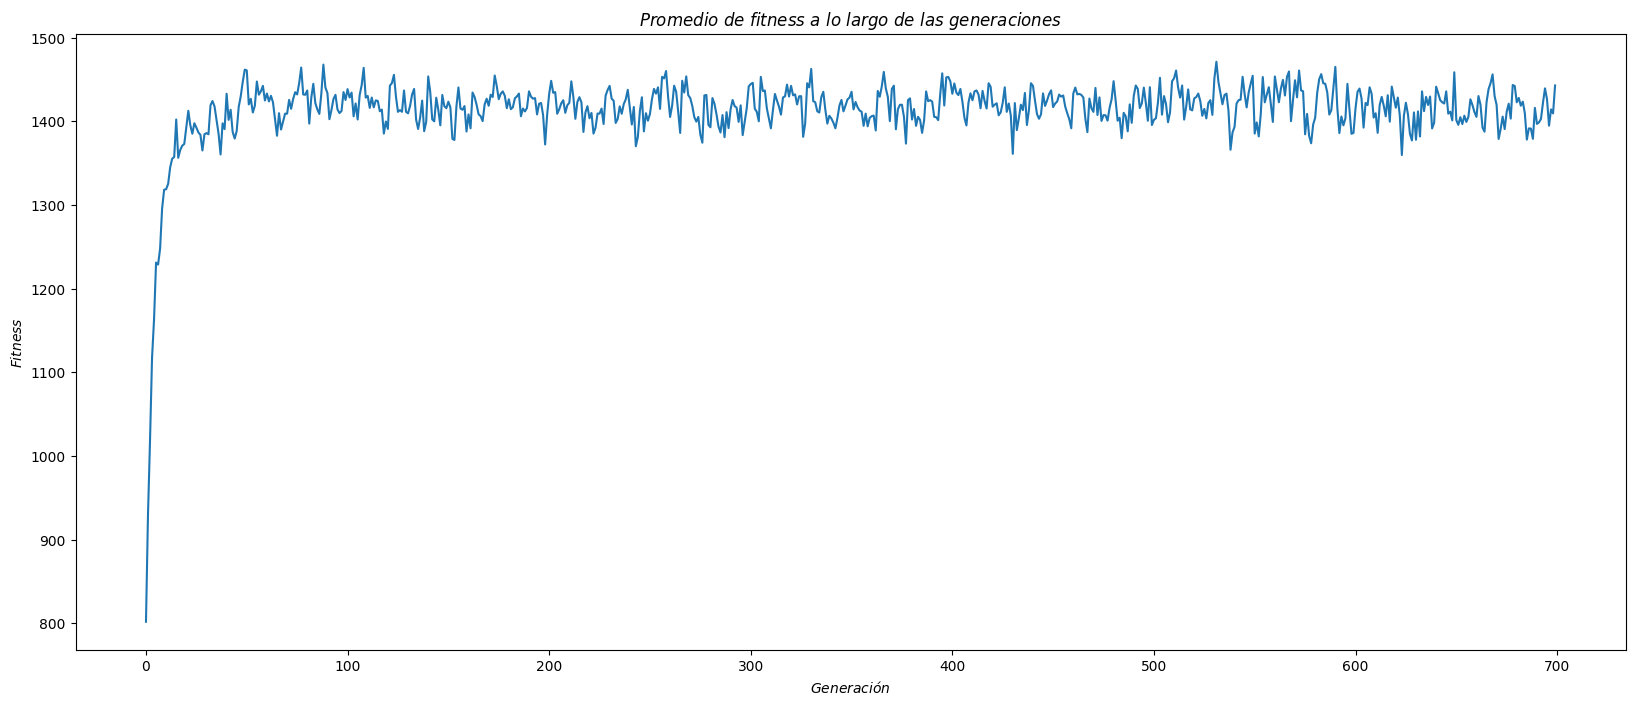

In [83]:
model_23.pop.mean_fitness()

**Modelo. Mutación = Swap**

In [84]:
model_24 = GeneticAlgorithm(population_2, class_select='rb',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.3,
                           fitness_func=fitness, max_gen=700)
model_24_bestind, model_24_bestfit = model_24.run()
print("Best individual: ",''.join(model_24_bestind))
print("Best fitness: ",model_24_bestfit)

  0%|          | 0/700 [00:00<?, ?it/s]

Best individual:  FF[F+][F-]F[F+F]
Best fitness:  1545


In [85]:
index=11
best_finalind[index]=model_24_bestind
best_gen_inds[index]=model_24.pop.best_ind.flatten()

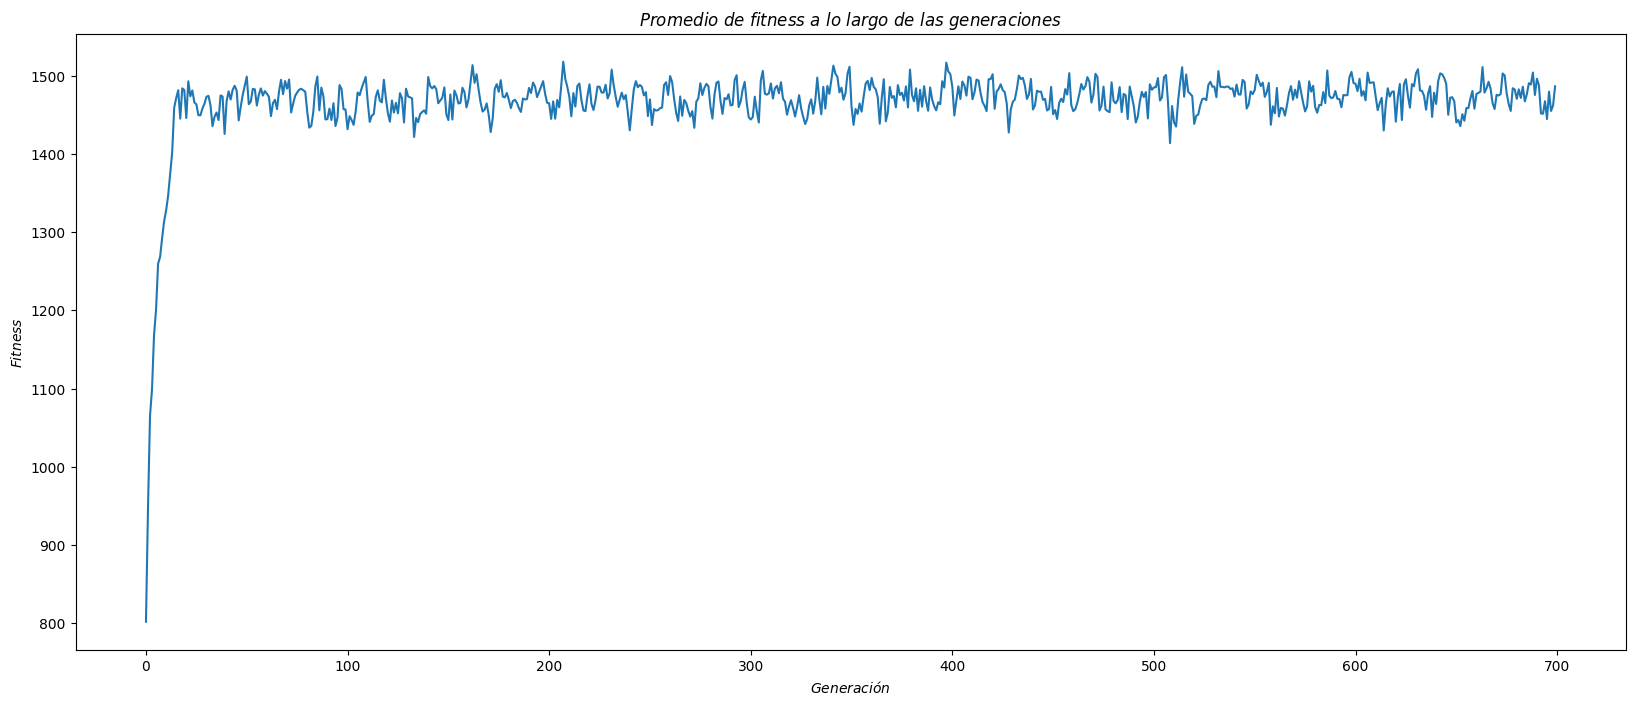

In [86]:
model_24.pop.mean_fitness()

**Se guarda la información de las matrices en ficheros numpy para su posterior visualización**

In [87]:
np.save('best_final_ind_exp2.npy', best_finalind)
np.save('best_gen_inds_exp2.npy', best_gen_inds)